# Setup

Install as needed.

In [ ]:
#install.packages("irr")
#install.packages("ggplot2")
#install.packages("dplyr")
#install.packages("tidyr")

Load modules.

In [ ]:
library(irr)
library(ggplot2)
library(dplyr)
library(tidyr)
library(parallel)
library(scales)
theme_set(theme_bw())

In [39]:
# Downloads and analyzes AFL plot_data (approx. 8 hours, 0.5 Terrabyte)
MEASURE_DETAILS = FALSE

RANKING_TIES_METHOD="random"

experiments = c(
    "2021-02-17-bug-paper"
  )

trials_experiments = c(
  "2021-08-19-crash-s",
  "2021-08-19-crash-s2"
)

notbuggy_benchmarks = c("file_magic_fuzzer",
                        "systemd_fuzz-varlink",
                        "muparser_set_eval_fuzzer",
                        "usrsctp_fuzzer_connect",
                        "proj4_standard_fuzzer",
                        "tpm2_tpm2_execute_command_fuzzer",
                        "libarchive_libarchive_fuzzer",
                        "ffmpeg_ffmpeg_demuxer_fuzzer" # No coverage
                        )

# Rename benchmarks for pretty printing
to_name = function(benchname) {
  if (benchname == "php_php-fuzz-execute") return("php-execute")
  if (benchname == "php_php-fuzz-parser-2020-07-25") return("php-parser")
  return(strsplit(benchname,"_")[[1]][1])
}

# Download fuzzbench coverage data.
fuzzbench_load <- function(Experiment) {
  url = paste(Experiment,"-fixed2.csv.gz",sep="")

  # Uncomment to download non-deduplicated data
  #url = paste("https://www.fuzzbench.com/reports/",Experiment,"/data.csv.gz",sep="")
  #tmp <- tempfile()
  #download.file(url,tmp)

  data <- read.csv(
    gzfile(url),
    sep=",",
    header=TRUE,
    stringsAsFactors=FALSE)
  
  return(subset(data,experiment == Experiment))
}

# Download Fuzzbench Data

## 60 Trials of 23 hours

In [40]:
trials_d = fuzzbench_load(trials_experiments[1])
#print(head(d,2))
for (experiment in tail(trials_experiments,-1)) {
  trials_d = rbind(trials_d, fuzzbench_load(experiment))
  #print(head(fuzzbench_load(experiment),2))
}

# Cleanup data. Some trials are recorded twice.
trials_d = trials_d %>%
  group_by(experiment,fuzzer,benchmark,time,trial_id) %>%
  summarize(edges_covered = mean(edges_covered),
            bugs_covered = mean(bugs_covered))

# Merge first 23 hours of 10 trials from 7d experiments.
#trials_d = rbind(trials_d, subset(long_d, time <= 23*3600))

trials_d$fuzzer = as.factor(trials_d$fuzzer)
trials_d$benchmark = as.factor(trials_d$benchmark)

print("Subjects")
trials_d %>% group_by(benchmark) %>% summarize(bugs = max(bugs_covered), branches=max(edges_covered))

trials_d %>% group_by(benchmark) %>% summarize(bugs = max(bugs_covered), branches=max(edges_covered)) %>% group_by() %>% summarize(bugs = sum(bugs), branches=sum(branches))

trials_dm = trials_d %>%
  group_by(fuzzer, benchmark, time) %>%
  summarize(edges = mean(edges_covered, na.rm=TRUE),
            bugs = mean(bugs_covered, na.rm=TRUE))

print("Number of fuzzers finding no bugs in the benchmark:")
subset(trials_dm, time == 23*3600 & bugs == 0) %>% group_by(benchmark) %>% summarize(n = n())

print("Average trials for each benchmark")
trials_d %>%
  group_by(fuzzer, benchmark, time) %>%
  summarize(trials = n()) %>%
  group_by(benchmark) %>%
  summarize(trials = mean(trials))

print(paste("Filtering ",notbuggy_benchmarks))
trials_d = subset(trials_d, !benchmark %in% notbuggy_benchmarks)

`summarise()` has grouped output by 'experiment', 'fuzzer', 'benchmark', 'time'. You can override using the `.groups` argument.



[1] "Subjects"


benchmark,bugs,branches
<fct>,<dbl>,<dbl>
arrow_parquet-arrow-fuzz,43,5409
ffmpeg_ffmpeg_demuxer_fuzzer,11,0
libarchive_libarchive_fuzzer,1,11974
matio_matio_fuzzer,5,2902
ndpi_fuzz_ndpi_reader,6,12557
njs_njs_process_script_fuzzer,1,7967
openh264_decoder_fuzzer,7,14422
poppler_pdf_fuzzer,4,38844
proj4_standard_fuzzer,0,10601


bugs,branches
<dbl>,<dbl>
84,605399


`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.



[1] "Number of fuzzers finding no bugs in the benchmark:"


benchmark,n
<fct>,<int>
libarchive_libarchive_fuzzer,7
ndpi_fuzz_ndpi_reader,2
njs_njs_process_script_fuzzer,4
proj4_standard_fuzzer,10
tpm2_tpm2_execute_command_fuzzer,10
wireshark_fuzzshark_ip,1


[1] "Average trials for each benchmark"


`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.



benchmark,trials
<fct>,<dbl>
arrow_parquet-arrow-fuzz,59.92935
ffmpeg_ffmpeg_demuxer_fuzzer,59.99879
libarchive_libarchive_fuzzer,59.99891
matio_matio_fuzzer,59.90459
ndpi_fuzz_ndpi_reader,60.00000
njs_njs_process_script_fuzzer,60.00000
openh264_decoder_fuzzer,59.98478
poppler_pdf_fuzzer,60.00000
proj4_standard_fuzzer,59.97717


[1] "Filtering  file_magic_fuzzer"               
[2] "Filtering  systemd_fuzz-varlink"            
[3] "Filtering  muparser_set_eval_fuzzer"        
[4] "Filtering  usrsctp_fuzzer_connect"          
[5] "Filtering  proj4_standard_fuzzer"           
[6] "Filtering  tpm2_tpm2_execute_command_fuzzer"
[7] "Filtering  libarchive_libarchive_fuzzer"    
[8] "Filtering  ffmpeg_ffmpeg_demuxer_fuzzer"    


## 20 Trials of 23 hours
Merged with 20 random trials for other programs using the data from the experiments above

In [6]:
d = fuzzbench_load(experiments[1])
#print(head(d,2))
for (experiment in tail(experiments,-1)) {
  d = rbind(d, fuzzbench_load(experiment))
  #print(head(fuzzbench_load(experiment),2))
}

# Cleanup data. Some trials are recorded twice.
d = d %>%
  group_by(experiment,fuzzer,benchmark,time,trial_id) %>%
  summarize(edges_covered = mean(edges_covered),
            bugs_covered = mean(bugs_covered))

d$fuzzer = as.factor(d$fuzzer)
d$benchmark = as.factor(d$benchmark)

# Merge first 20 trials of subjects in trials experiments.
d = rbind(
    trials_d,
    d) %>% 
  group_by(fuzzer,benchmark,time) %>% 
  top_n(20, as.integer(trial_id))

print("Subjects before pruning")
a = d %>% group_by(benchmark) %>% summarize(bugs = max(bugs_covered), branches=max(edges_covered))
a
a %>% group_by() %>% summarize(bugs = sum(bugs), branches=sum(branches))

print(paste("Filtering ",notbuggy_benchmarks))
d = subset(d, !benchmark %in% notbuggy_benchmarks)

print("Subjects after pruning")
a = d %>% group_by(benchmark) %>% summarize(bugs = max(bugs_covered), branches=max(edges_covered))
a

a %>% group_by() %>% summarize(bugs = sum(bugs), branches=sum(branches))


summary(d)

`summarise()` has grouped output by 'experiment', 'fuzzer', 'benchmark', 'time'. You can override using the `.groups` argument.



[1] "Subjects before pruning"


benchmark,bugs,branches
<fct>,<dbl>,<dbl>
arrow_parquet-arrow-fuzz,43,5370
matio_matio_fuzzer,5,2896
ndpi_fuzz_ndpi_reader,6,12053
njs_njs_process_script_fuzzer,1,7967
openh264_decoder_fuzzer,6,14403
poppler_pdf_fuzzer,3,38627
wireshark_fuzzshark_ip,2,492013
aspell_aspell_fuzzer,7,6854
file_magic_fuzzer,1,4482


bugs,branches
<dbl>,<dbl>
108,921546


[1] "Filtering  file_magic_fuzzer"               
[2] "Filtering  systemd_fuzz-varlink"            
[3] "Filtering  muparser_set_eval_fuzzer"        
[4] "Filtering  usrsctp_fuzzer_connect"          
[5] "Filtering  proj4_standard_fuzzer"           
[6] "Filtering  tpm2_tpm2_execute_command_fuzzer"
[7] "Filtering  libarchive_libarchive_fuzzer"    
[8] "Filtering  ffmpeg_ffmpeg_demuxer_fuzzer"    
[1] "Subjects after pruning"


benchmark,bugs,branches
<fct>,<dbl>,<dbl>
arrow_parquet-arrow-fuzz,43,5370
matio_matio_fuzzer,5,2896
ndpi_fuzz_ndpi_reader,6,12053
njs_njs_process_script_fuzzer,1,7967
openh264_decoder_fuzzer,6,14403
poppler_pdf_fuzzer,3,38627
wireshark_fuzzshark_ip,2,492013
aspell_aspell_fuzzer,7,6854
grok_grk_decompress_fuzzer,2,9582


bugs,branches
<dbl>,<dbl>
106,902320


  experiment             fuzzer                               benchmark     
 Length:305237      afl     : 31280   arrow_parquet-arrow-fuzz     : 18400  
 Class :character   aflfast : 31280   njs_njs_process_script_fuzzer: 18400  
 Mode  :character   aflsmart: 31280   openh264_decoder_fuzzer      : 18400  
                    entropic: 31280   libgit2_objects_fuzzer       : 18400  
                    fairfuzz: 31280   libhtp_fuzz_htp              : 18400  
                    mopt    : 31280   php_php-fuzz-execute         : 18400  
                    (Other) :117557   (Other)                      :194837  
      time          trial_id       edges_covered     bugs_covered   
 Min.   :  900   Min.   : 990286   Min.   :     0   Min.   : 0.000  
 1st Qu.:20700   1st Qu.: 992324   1st Qu.:  4384   1st Qu.: 0.000  
 Median :41400   Median :1000125   Median :  8426   Median : 1.000  
 Mean   :41834   Mean   :1214982   Mean   : 42792   Mean   : 2.641  
 3rd Qu.:62100   3rd Qu.:1548348   3rd 

## Compute Averages Data Frame

In [7]:
dm = d %>%
  group_by(fuzzer, benchmark, time) %>%
  summarize(edges = mean(edges_covered, na.rm=TRUE),
            bugs = mean(bugs_covered, na.rm=TRUE))

print("Number of fuzzers finding no bugs in the benchmark:")
subset(dm, time == 23*3600 & bugs == 0) %>% group_by(benchmark) %>% summarize(n = n())

print("Average trials for each benchmark")
d %>%
  group_by(fuzzer, benchmark, time) %>%
  summarize(trials = n()) %>%
  group_by(benchmark) %>%
  summarize(trials = mean(trials))

# Filter ineffective fuzzers if needed
#dm = subset(dm, ifelse(FILTER_INEFFECTIVE_FUZZERS,bugs > 0,TRUE))

`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.



[1] "Number of fuzzers finding no bugs in the benchmark:"


benchmark,n
<fct>,<int>
ndpi_fuzz_ndpi_reader,3
njs_njs_process_script_fuzzer,4
wireshark_fuzzshark_ip,1
aspell_aspell_fuzzer,5
grok_grk_decompress_fuzzer,1
libhevc_hevc_dec_fuzzer,2
php_php-fuzz-execute,2
zstd_stream_decompress,2


[1] "Average trials for each benchmark"


`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.



benchmark,trials
<fct>,<dbl>
arrow_parquet-arrow-fuzz,20.00000
matio_matio_fuzzer,20.00000
ndpi_fuzz_ndpi_reader,20.00000
njs_njs_process_script_fuzzer,20.00000
openh264_decoder_fuzzer,20.00000
poppler_pdf_fuzzer,20.00000
wireshark_fuzzshark_ip,20.00000
aspell_aspell_fuzzer,19.95326
grok_grk_decompress_fuzzer,19.99783


# RQ1. Correlation 

Across all runs, across all fuzzers

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

Saving 7.7 x 7.7 in image



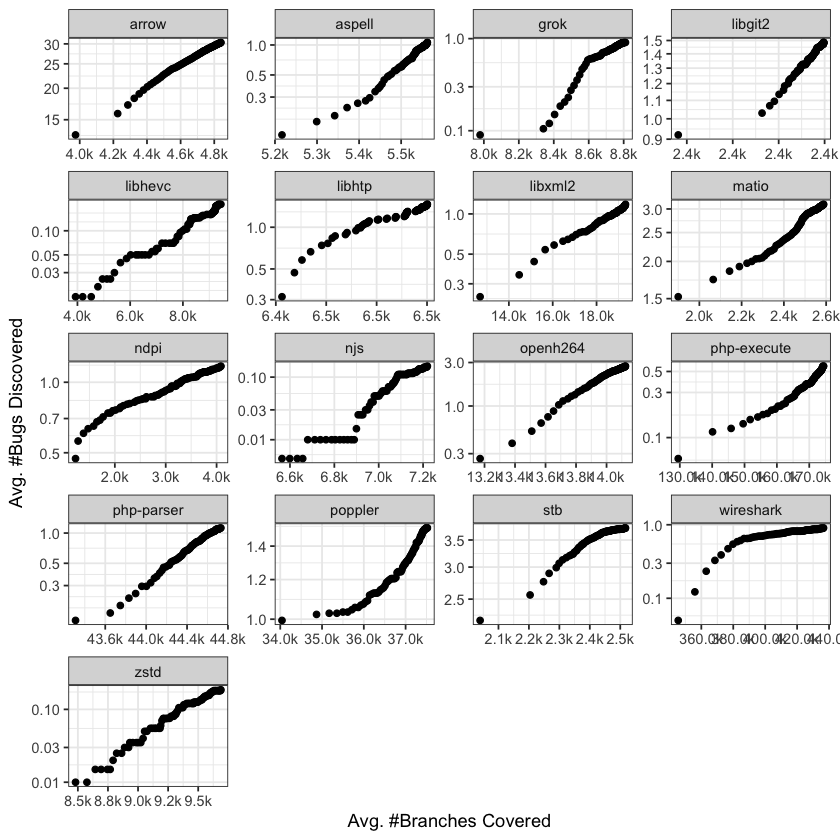

In [8]:
defaultW <- getOption("warn")
options(warn = -1)

dmall = d %>% 
      group_by(benchmark, time) %>%
      summarize(edges = mean(edges_covered), bugs=mean(bugs_covered))
# Remove data points without bugs
dmall = subset(dmall, bugs > 0)

dmall_correlation = dmall %>%
      group_by(benchmark) %>%
      summarize(correlation = cor(edges,bugs,method="spearman",use="pairwise")) %>%
      mutate(text = paste("Correlation: ", format(round(correlation,digits=4),digits=4),"\n")) 

dmall = dmall %>% mutate(benchmark = to_name(as.character(benchmark)))

#remove outlier
dmall = subset(dmall, !((benchmark=="libhtp" | benchmark=="php-parser") & time <= 1800))

ggplot(dmall, aes(edges,bugs)) +
  # Uncomment this line to see scatter plot for one fuzzer (aflplusplus), as well.
  #geom_point(data=subset(dm %>% mutate(benchmark = to_name(as.character(benchmark))),fuzzer=="aflplusplus"), color="gray") +
  geom_point() +
  scale_y_log10() + 
  scale_x_continuous(labels = label_number(suffix = "k", accuracy=0.1, scale = 1e-3)) + # millions
  xlab("Avg. #Branches Covered") +
  ylab("Avg. #Bugs Discovered") +
  guides(shape = guide_legend(override.aes = list(size = 2)),
         color = guide_legend(override.aes = list(size = 2))) +
  theme(legend.title = element_text(size = 6), 
        legend.text  = element_text(size = 6),
        legend.key.size = unit(0.8, "lines"),
        legend.position = c(0.85, 0.15)) +
  facet_wrap(~benchmark, scale="free", ncol = 4)

ggsave("correlation.all.pdf",scale=1.1, height=7)
options(warn = defaultW)

# Agreement on Ranking

## Figure 1. Visualize Agreement

In [9]:
dm_bugs_ranking = dm %>% 
  group_by(benchmark, time) %>% 
  mutate(edges_rank=rank(-edges, ties.method=RANKING_TIES_METHOD),
         bugs_rank=rank(-bugs, ties.method=RANKING_TIES_METHOD))
         
head(dm_bugs_ranking)

fuzzer,benchmark,time,edges,bugs,edges_rank,bugs_rank
<fct>,<fct>,<int>,<dbl>,<dbl>,<int>,<int>
afl,arrow_parquet-arrow-fuzz,900,4160.10,17.85,3,2
afl,arrow_parquet-arrow-fuzz,1800,4475.20,21.50,2,3
afl,arrow_parquet-arrow-fuzz,2700,4542.05,22.90,2,4
afl,arrow_parquet-arrow-fuzz,3600,4593.10,24.20,2,4
afl,arrow_parquet-arrow-fuzz,4500,4622.35,25.00,2,4
afl,arrow_parquet-arrow-fuzz,5400,4646.80,25.70,2,3



	Spearman's rank correlation rho

data:  subset(dm_bugs_ranking, time == 1 * 3600)$edges_rank and subset(dm_bugs_ranking, time == 1 * 3600)$bugs_rank
S = 430935, p-value = 4.843e-09
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4347317 



	Spearman's rank correlation rho

data:  subset(dm_bugs_ranking, time == 23 * 3600)$edges_rank and subset(dm_bugs_ranking, time == 23 * 3600)$bugs_rank
S = 395729, p-value = 5.453e-11
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4809123 


Saving 4.2 x 4.9 in image



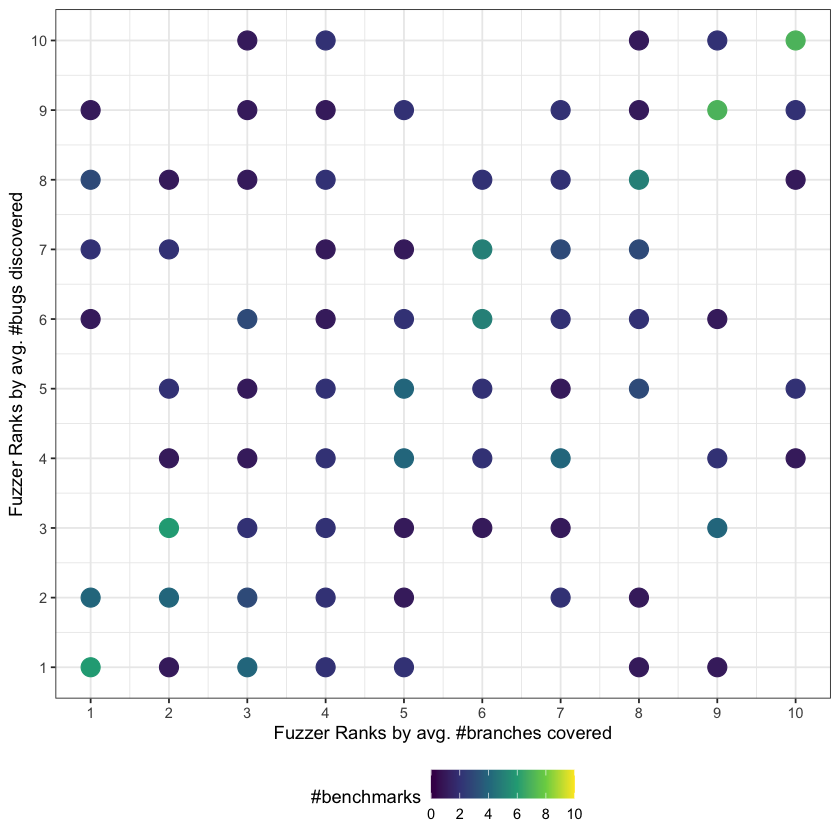

Saving 4.2 x 4.9 in image



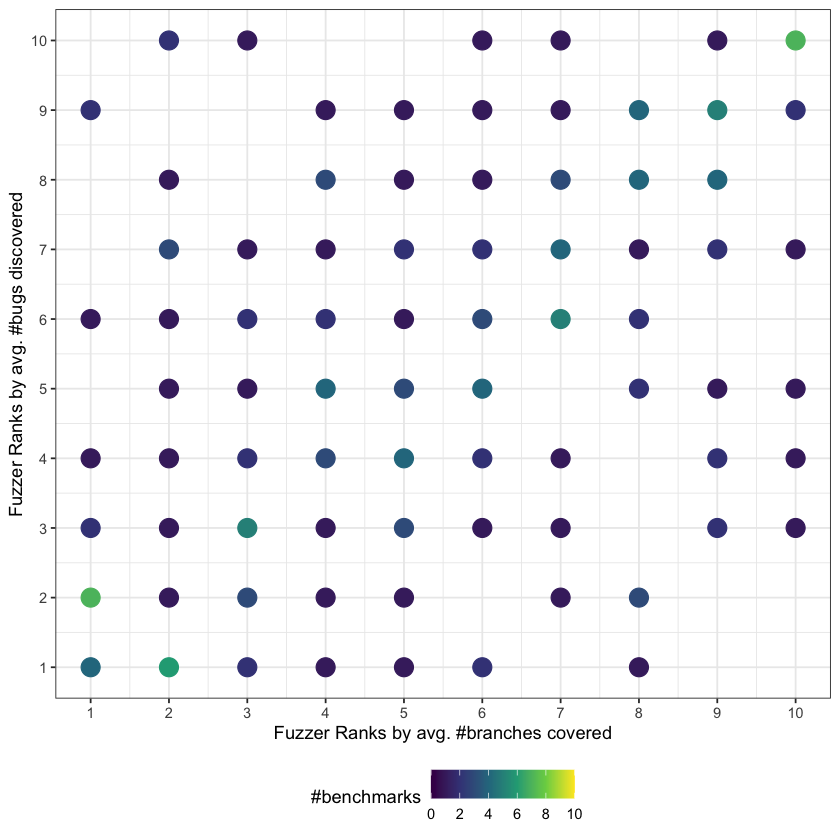

In [10]:
cor.test(
  subset(dm_bugs_ranking, time==1*3600)$edges_rank,
  subset(dm_bugs_ranking,time==1*3600)$bugs_rank, 
  method="spearman", use="pairwise")

cor.test(
  subset(dm_bugs_ranking, time==23*3600)$edges_rank,
  subset(dm_bugs_ranking,time==23*3600)$bugs_rank, 
  method="spearman", use="pairwise")

ggplot(subset(dm_bugs_ranking,time==3600),aes(edges_rank,bugs_rank)) +
  geom_count(size=5,aes(color=as.integer(..n..))) +
  scale_y_continuous(breaks=seq(1,10)) +
  scale_x_continuous(breaks=seq(1,10)) +
  scale_color_viridis_c(name="#benchmarks", breaks=pretty_breaks(), limits=c(0,10)) +
  xlab("Fuzzer Ranks by avg. #branches covered") +
  ylab("Fuzzer Ranks by avg. #bugs discovered") +
  theme(legend.direction="horizontal", legend.position="bottom")
  ggsave("agreement.all.1hr.pdf",scale=0.7,width=6)

ggplot(subset(dm_bugs_ranking,time==23*3600),aes(edges_rank,bugs_rank)) +
  geom_count(size=5,aes(color=as.integer(..n..))) +
  scale_y_continuous(breaks=seq(1,10)) +
  scale_x_continuous(breaks=seq(1,10)) +
  scale_color_viridis_c(name="#benchmarks", breaks=pretty_breaks(), limits=c(0,10)) +
  xlab("Fuzzer Ranks by avg. #branches covered") +
  ylab("Fuzzer Ranks by avg. #bugs discovered") +
  theme(legend.direction="horizontal", legend.position="bottom")
  ggsave("agreement.all.23hrs.pdf",scale=0.7,width=6)

## Figure 10. Ranking across trials

In [11]:
a = fuzzbench_load(experiments[1])
#print(head(d,2))
for (experiment in tail(experiments,-1)) {
  a = rbind(d, fuzzbench_load(experiment))
  #print(head(fuzzbench_load(experiment),2))
}

# Cleanup data. Some trials are recorded twice.
a = a %>%
  group_by(experiment,fuzzer,benchmark,time,trial_id) %>%
  summarize(edges_covered = mean(edges_covered),
            bugs_covered = mean(bugs_covered))

a$fuzzer = as.factor(a$fuzzer)
a$benchmark = as.factor(a$benchmark)

# Merge first 20 trials of subjects in trials experiments.
a = 
  rbind(
    trials_d,
    a) #%>% 
#  group_by(fuzzer,benchmark,time) %>% 
#  top_n(20, as.integer(trial_id))

subset(a, time == 23 * 3600 & fuzzer != "eclipser" & benchmark != "libhevc_hevc_dec_fuzzer" & benchmark != "arrow_parquet-arrow-fuzz") %>%
  group_by(fuzzer, benchmark) %>% tally()

`summarise()` has grouped output by 'experiment', 'fuzzer', 'benchmark', 'time'. You can override using the `.groups` argument.



fuzzer,benchmark,n
<fct>,<fct>,<int>
afl,matio_matio_fuzzer,59
afl,ndpi_fuzz_ndpi_reader,60
afl,njs_njs_process_script_fuzzer,60
afl,openh264_decoder_fuzzer,80
afl,poppler_pdf_fuzzer,60
afl,wireshark_fuzzshark_ip,56
afl,aspell_aspell_fuzzer,20
afl,file_magic_fuzzer,20
afl,grok_grk_decompress_fuzzer,20


`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'

Saving 3.15 x 3.15 in image

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'



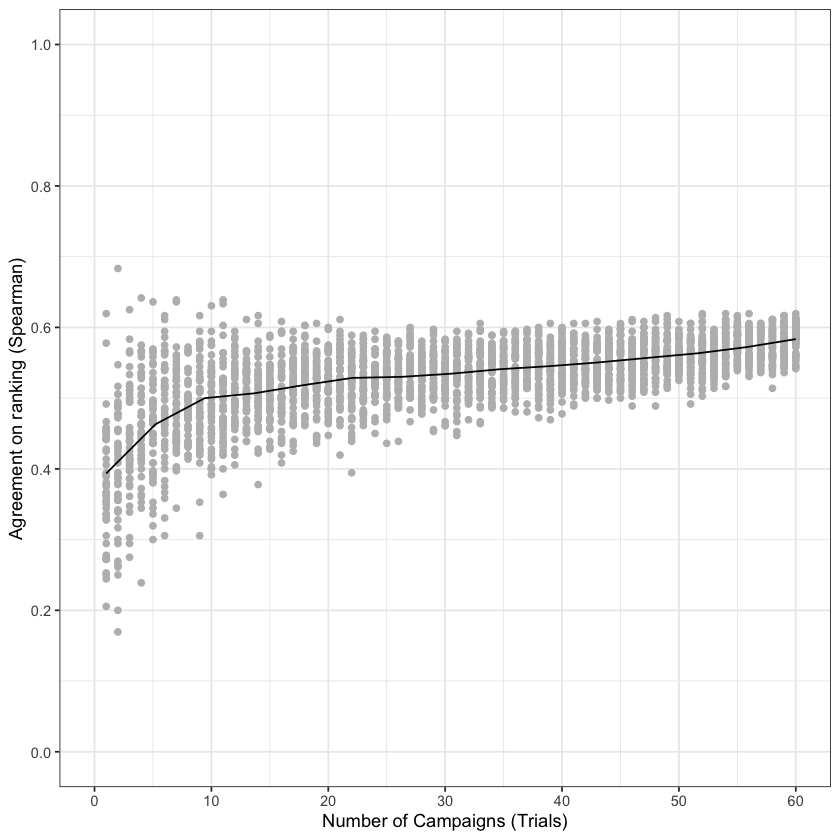

In [12]:
defaultW <- getOption("warn")
options(warn = -1)

n_trials=60
temp_df60 = NULL
for (repetition in seq(1,50)) {
  cors=c()
  for (trials in seq(1,n_trials)) {
    temp = 
      subset(trials_d, time == 23 * 3600 & fuzzer != "eclipser" & benchmark != "libhevc_hevc_dec_fuzzer" & benchmark != "arrow_parquet-arrow-fuzz") %>%
      group_by(fuzzer, benchmark, time) %>%
      summarize(edges = mean(sample(edges_covered,min(c(trials,length(edges_covered)))), na.rm=TRUE),
                bugs = mean(sample(bugs_covered,min(c(trials,length(bugs_covered)))), na.rm=TRUE),.groups = 'drop') %>%
                #bugs = mean(sample(bugs_covered,trials), na.rm=TRUE),.groups = 'drop') %>%
      group_by(benchmark) %>%
      mutate(edges_rank=rank(-edges, ties.method=RANKING_TIES_METHOD),
            bugs_rank=rank(-bugs, ties.method=RANKING_TIES_METHOD))
    cor = cor(temp$edges_rank, temp$bugs_rank, method="pearson", use="pairwise")
    cors=c(cors,cor)
  }
  if (repetition == 1) {
    temp_df60 = data.frame(trial_id=1,x=seq(1,n_trials),y=cors)
  } else {
    temp_df60 = rbind(temp_df60, data.frame(trial_id=repetition, x=seq(1,n_trials),y=cors))
  }
}
temp_dm60 = temp_df60 %>% group_by(x) %>% summarize(y=mean(y))

options(warn = defaultW)

# GET EQUATION AND R-SQUARED AS STRING
# SOURCE: https://groups.google.com/forum/#!topic/ggplot2/1TgH-kG5XMA

lm_eqn <- function(df){
    m <- lm(y ~ x, df);
    eq <- substitute(italic(y) == a + b %.% italic(x)*","~~italic(r)^2~"="~r2, 
         list(a = format(unname(coef(m)[1]), digits = 2),
              b = format(unname(coef(m)[2]), digits = 2),
             r2 = format(summary(m)$r.squared, digits = 3)))
    as.character(as.expression(eq));
}

ggplot(temp_df60,aes(x,y)) +
  #geom_smooth(data=subset(temp_df60,x>=10), method = "lm", se=FALSE, color="darkgrey") +
  geom_point(color="#bbbbbb") +
  stat_smooth(geom='line', n=15)+
  #geom_text(x = -Inf, y = Inf, hjust = -0.1, vjust = 1.1, label = lm_eqn(subset(temp_df60,x>=10)), parse = TRUE) +
  scale_y_continuous(limits=c(0,1),breaks=seq(0,1,0.2), name=c("Agreement on ranking (Spearman)")) +
  scale_x_continuous(breaks=seq(0,60,10), limits=c(0,60), name=c("Number of Campaigns (Trials)"))
ggsave("agreement.trials.60.pdf",scale=0.45)

## Ranking across time stamps per benchmark

In [13]:
dm_bugs_ranking_correlation = dm_bugs_ranking  %>%
  group_by(benchmark) %>%
  summarize(
      correlation=cor(edges_rank,bugs_rank, method="pearson", use="pairwise"),
      text = paste(format(round(correlation,digits=2),digits=2))
  )

dm_bugs_ranking_correlation


benchmark,correlation,text
<fct>,<dbl>,<chr>
arrow_parquet-arrow-fuzz,0.902898551,0.9
matio_matio_fuzzer,0.782246377,0.78
ndpi_fuzz_ndpi_reader,0.840398551,0.84
njs_njs_process_script_fuzzer,-0.311857708,-0.31
openh264_decoder_fuzzer,0.398550725,0.4
poppler_pdf_fuzzer,0.751630435,0.75
wireshark_fuzzshark_ip,0.845652174,0.85
aspell_aspell_fuzzer,0.357971014,0.36
grok_grk_decompress_fuzzer,0.677206851,0.68


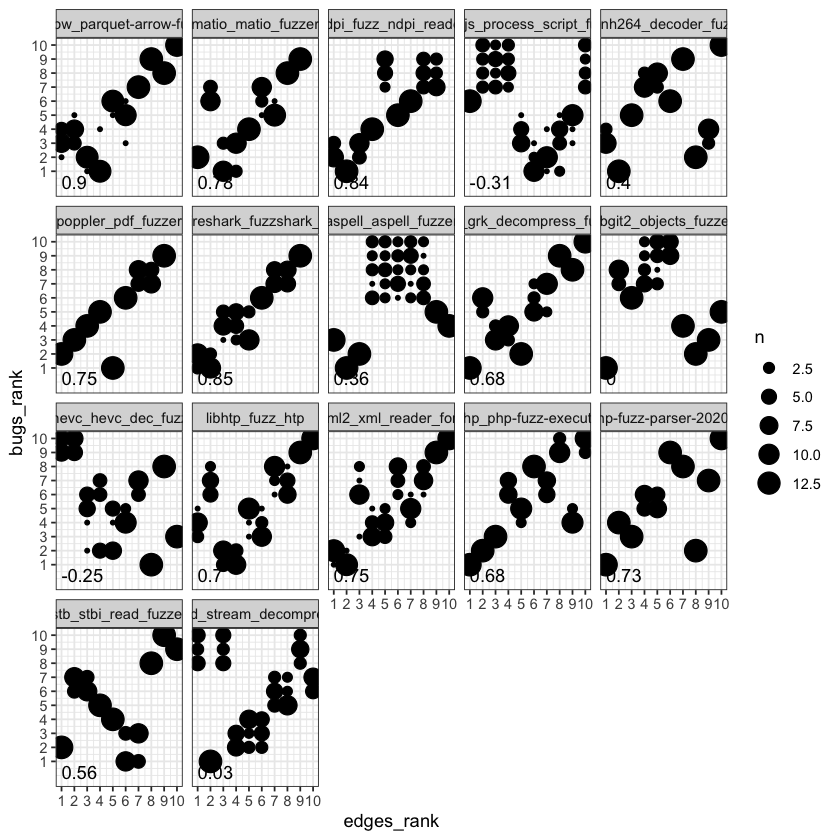

In [14]:
ggplot(subset(dm_bugs_ranking, time>=20*3600),aes(edges_rank,bugs_rank)) +
  geom_count() +
  geom_text(data=dm_bugs_ranking_correlation, x=1, y=-0.2, 
            hjust="left", vjust="bottom", aes(label=text)) +
  expand_limits(y = -0.3) +
  scale_y_continuous(breaks=seq(1,10)) +
  scale_x_continuous(breaks=seq(1,10)) +
  facet_wrap(~benchmark)

## Ranking across Benchmarks per time stamp

Saving 3.15 x 3.15 in image



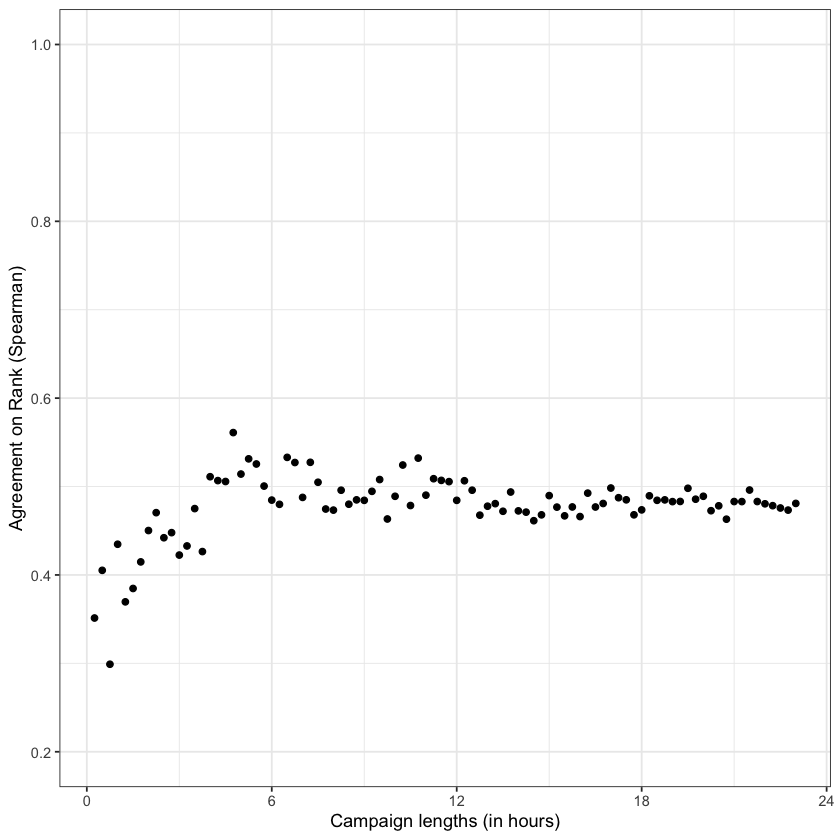

In [15]:
dm_bugs_ranking_correlation = 
  subset(dm_bugs_ranking, 
         # WE ARE CONSERVATIVELY EXCLUDING THE WORST RANK (10)
         TRUE #ifelse(FILTER_INEFFECTIVE_FUZZERS, TRUE, bugs_rank < 10 & edges_rank < 10)
         )  %>%
  group_by(time) %>%
  summarize(
      correlation=cor(edges_rank,bugs_rank, method="spearman", use="pairwise"),
      text = paste(format(round(correlation,digits=2),digits=2))
      )

ggplot(dm_bugs_ranking_correlation, aes(time/3600,correlation)) +
  #geom_rect(ymin = -Inf, ymax = lwWt, xmin = -Inf, xmax = Inf, fill = 'darkorange') +
  geom_point() +
  scale_x_continuous(breaks=seq(0,24,6), name=c("Campaign lengths (in hours)")) +
  scale_y_continuous(limits=c(0.2,1.0), name=c("Agreement on Rank (Spearman)"))
  
  
ggsave("agreement.over.time.pdf",scale=0.45)

Saving 14 x 14 in image



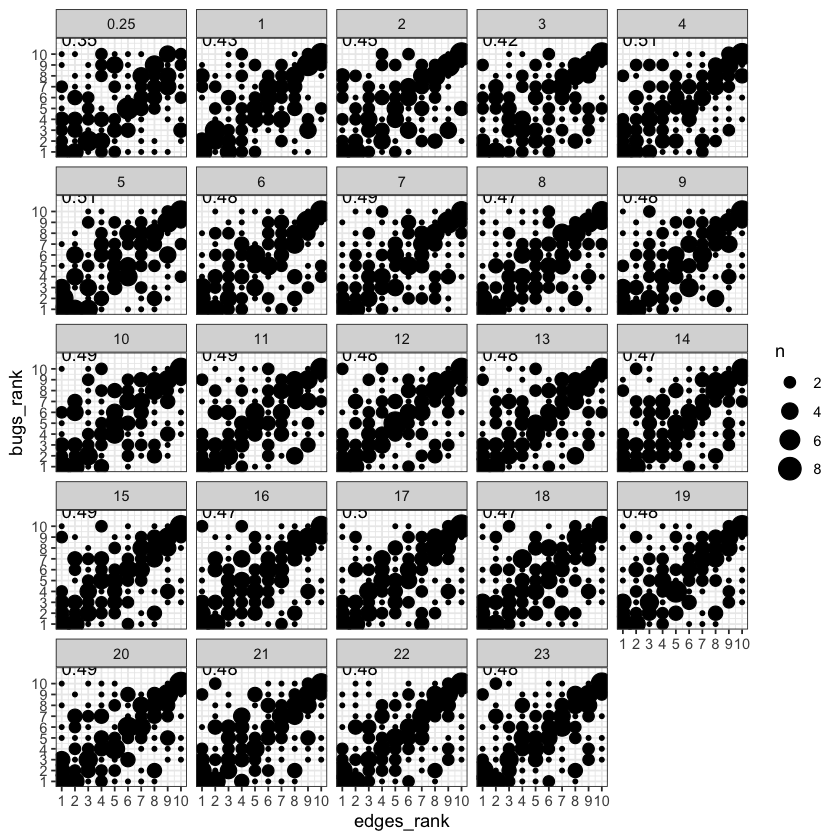

In [16]:
dm_bugs_ranking_hourly = subset(dm_bugs_ranking, time %in% c(seq(0,23)*3600,900))
dm_bugs_ranking_correlation_hourly = subset(dm_bugs_ranking_correlation, time %in% c(seq(0,23)*3600,900))

ggplot(dm_bugs_ranking_hourly,aes(edges_rank,bugs_rank)) +
  geom_count() +
  geom_text(data=dm_bugs_ranking_correlation_hourly, x=1, y=10.8, 
            hjust="left", vjust="bottom", aes(label=text)) +
  expand_limits(y = 11) +
  scale_y_continuous(breaks=seq(1,10)) +
  scale_x_continuous(breaks=seq(1,10)) +
  facet_wrap(~time/3600)
ggsave("agreement.timestamp.pdf",scale=2)

## Figure 11. Agreement with Final Measure across Time

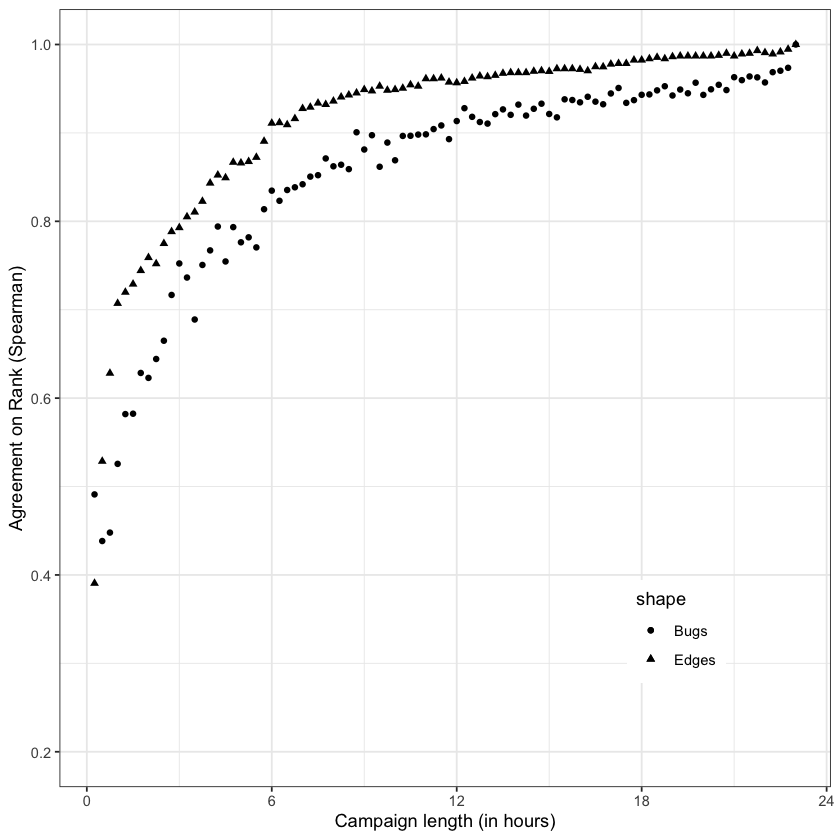

In [17]:
tmp = subset(dm_bugs_ranking, time==82800) %>% 
    group_by(fuzzer, benchmark) %>% 
    summarize(final_edges_rank = edges_rank, final_bugs_rank = bugs_rank)

dm_bugs_ranking = tmp %>% 
    left_join(dm_bugs_ranking)

dm_bugs_ranking_correlation = 
    subset(dm_bugs_ranking, 
           # WE ARE CONSERVATIVELY EXCLUDING THE WORST RANK (10)
           TRUE #ifelse(FILTER_INEFFECTIVE_FUZZERS, TRUE, bugs_rank < 10 & edges_rank < 10)
           )  %>%
    group_by(time) %>%
    summarize(
      edges_correlation=cor(edges_rank,final_edges_rank, method="spearman", use="pairwise"),
      edges_text = paste("Spearman's p =",format(round(edges_correlation,digits=2),digits=2)),
      bugs_correlation=cor(bugs_rank,final_bugs_rank, method="spearman", use="pairwise"),
      bugs_text = paste("Spearman's p =",format(round(bugs_correlation,digits=2),digits=2))
    )

ggplot(dm_bugs_ranking_correlation) +
  geom_point(aes(time/3600,edges_correlation,shape="Edges")) +
  geom_point(aes(time/3600,bugs_correlation,shape="Bugs")) +
  #stat_smooth(aes(time/3600,edges_correlation), geom='line', n=48)+
  #stat_smooth(aes(time/3600,bugs_correlation), geom='line', n=48)+
  scale_x_continuous(breaks=seq(0,24,6), name=c("Campaign length (in hours)")) +
  scale_y_continuous(limits=c(0.2,1),name=c("Agreement on Rank (Spearman)")) +
  theme(legend.position = c(0.8, 0.2))
ggsave("self.agreement.over.time.pdf",scale=0.45)

`summarise()` has grouped output by 'time'. You can override using the `.groups` argument.



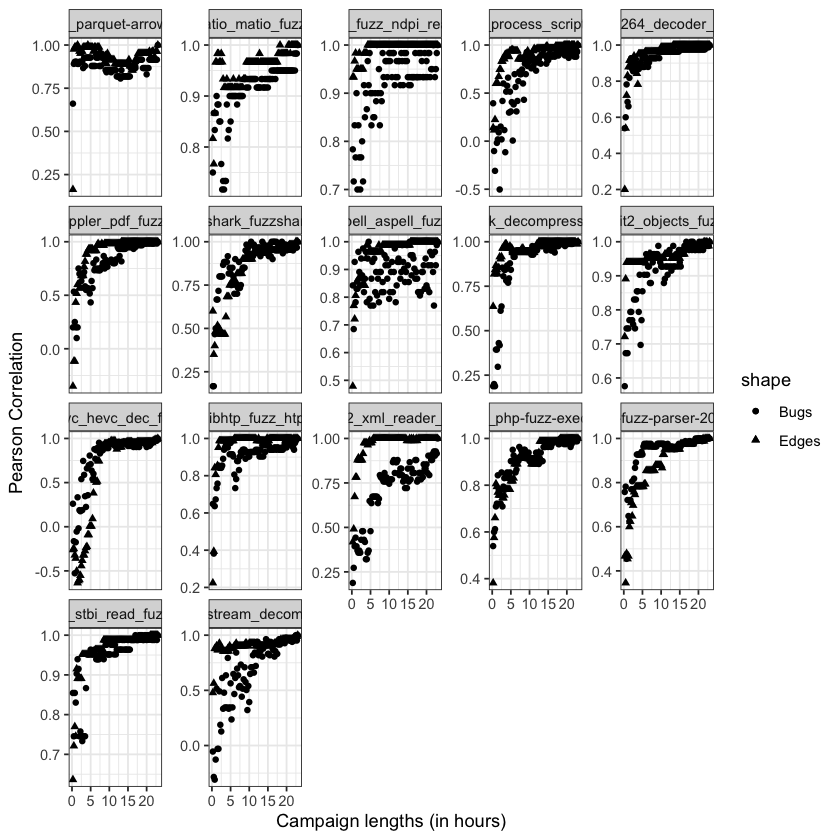

In [18]:
dm_bugs_ranking_correlation_all = 
    subset(dm_bugs_ranking, 
           # WE ARE CONSERVATIVELY EXCLUDING THE WORST RANK (10)
           TRUE #ifelse(FILTER_INEFFECTIVE_FUZZERS, TRUE, bugs_rank < 10 & edges_rank < 10)
           )  %>%
    group_by(time,benchmark) %>%
    summarize(
      edges_correlation=cor(edges_rank,final_edges_rank, method="pearson", use="pairwise"),
      edges_text = paste(format(round(edges_correlation,digits=2),digits=2)),
      bugs_correlation=cor(bugs_rank,final_bugs_rank, method="pearson", use="pairwise"),
      bugs_text = paste(format(round(bugs_correlation,digits=2),digits=2))
    )

ggplot(dm_bugs_ranking_correlation_all) +
  geom_point(aes(time/3600,edges_correlation,shape="Edges")) +
  geom_point(aes(time/3600,bugs_correlation,shape="Bugs")) +
  ylab("Pearson Correlation") + 
  xlab("Campaign lengths (in hours)") +
  facet_wrap(~benchmark,scales="free_y")


Saving 3.85 x 3.85 in image



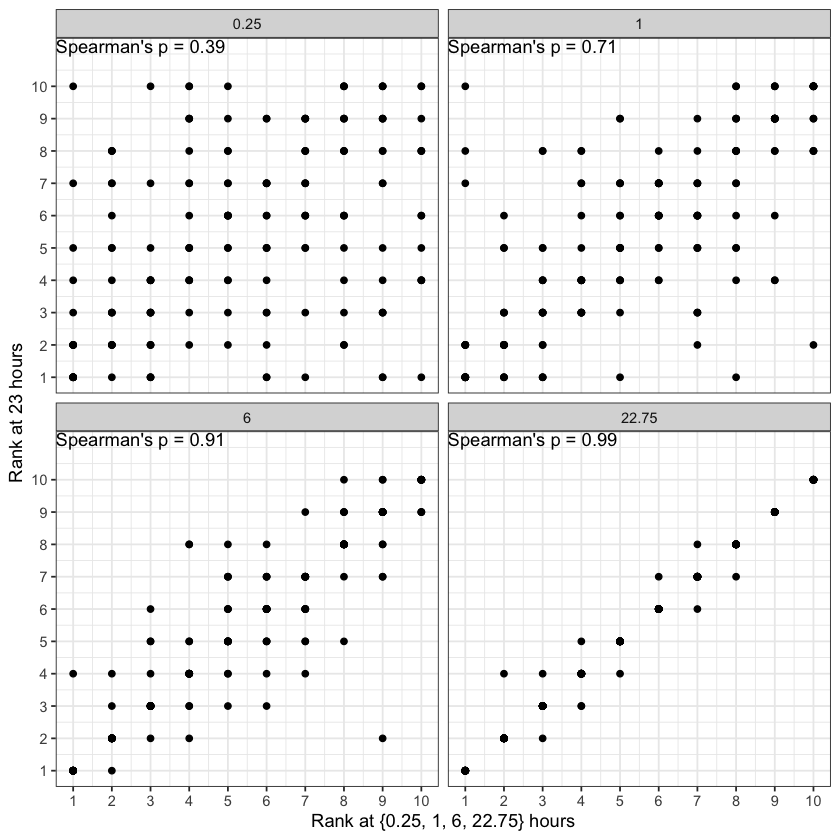

In [19]:
dm_bugs_ranking_hourly = subset(dm_bugs_ranking, time %in% c(900,3600,6*3600,22.75*3600))#time %in% c(seq(0,23)*3600,900))
dm_bugs_ranking_correlation_hourly = subset(dm_bugs_ranking_correlation, time %in% c(900,3600,6*3600,22.75*3600))
ggplot(dm_bugs_ranking_hourly,aes(edges_rank,final_edges_rank)) +
  geom_point() +
  geom_text(data=dm_bugs_ranking_correlation_hourly, x=-Inf, y=Inf, 
            hjust=0, vjust=1.1, aes(label=edges_text)) +
  expand_limits(y = 11) +
  scale_y_continuous(breaks=seq(1,10),name=c("Rank at 23 hours")) +
  scale_x_continuous(breaks=seq(1,10),name=c("Rank at {0.25, 1, 6, 22.75} hours")) +
  facet_wrap(~time/3600,ncol=2)
ggsave("agreement.cov.vs.finalcov.pdf",scale=0.55)

Saving 14 x 14 in image



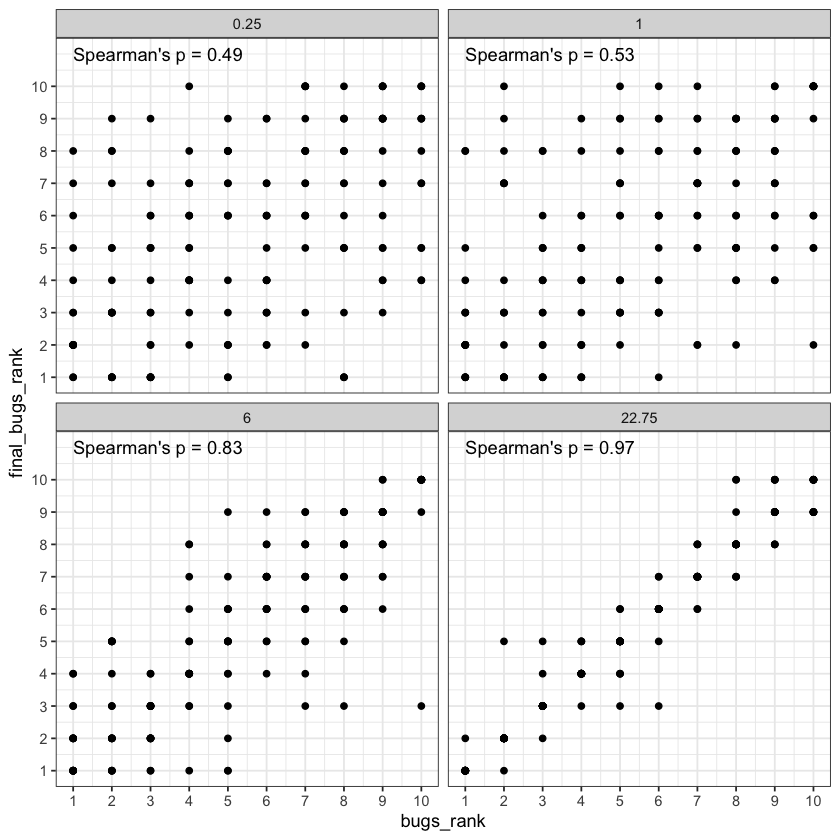

In [20]:
ggplot(dm_bugs_ranking_hourly,aes(bugs_rank,final_bugs_rank)) +
  #geom_count() +
  geom_point() +
  geom_text(data=dm_bugs_ranking_correlation_hourly, x=1, y=10.8, 
            hjust="left", vjust="bottom", aes(label=bugs_text)) +
  expand_limits(y = 11) +
  scale_y_continuous(breaks=seq(1,10)) +
  scale_x_continuous(breaks=seq(1,10)) +
  facet_wrap(~time/3600)
ggsave("agreement.bug.vs.finalbug.pdf",scale=2)

# Incorporate other Measures of Coverage and Bug Finding
## Download More Fuzzbench Data (0.5 terrabyte)

In [21]:
randomString <- function(n = 1) {
  a <- do.call(paste0, replicate(5, sample(LETTERS, n, TRUE), FALSE))
  paste0(a, sprintf("%04d", sample(9999, n, TRUE)), sample(LETTERS, n, TRUE))
}

fuzzbench_read_aflplotdata <- function(data) {
  plotdata_files = c(
    "corpus/plot_data", # AFL and derivatives
    "corpus/default/plot_data", # AFL++
    "corpus/afl-worker/plot_data" # Eclipser
  )
  datapoint = max_time / 900

  return(do.call(
    rbind, 
    mclapply(
      data$trial_id,
      function(trial) {
        specific = subset(data, trial_id == trial)
        url = paste("https://storage.googleapis.com/fuzzbench-data/",
               specific$experiment,"/experiment-folders/",
               specific$benchmark,"-",specific$fuzzer,"/trial-",trial,"/",
              "corpus/corpus-archive-", sprintf("%04d",datapoint),".tar.gz",sep="")

        tmp <- paste("/tmp/",randomString(),".tar.gz",sep="")
        tmp2 <- paste("/tmp/",randomString(),sep="")

        prefix = dirname(url)
        current_datapoint = datapoint

      
        # Disable warnings for downloads and decompression
        defaultW <- getOption("warn")
        #options(warn = -1)

        while (!file.exists(tmp)) {

          if (current_datapoint == 0) {
            print(paste("[ERROR] Could not download from ", prefix,".",sep=""))
            return(specific) # ERROR
          }

          url = paste(prefix,"/corpus-archive-", sprintf("%04d",current_datapoint),".tar.gz",sep="")
          print(paste("[INFO] Downloading",url,"to",tmp))
          tryCatch(
            system(paste("curl -s -f -o", tmp, url)),
            #download.file(url, tmp),
            error = function(e) {
              print(e)
              if(file.exists(tmp)) {
                file.remove(tmp)
              }
            },
            warning = function(e) {
              print(e)
              if (file.exists(tmp)) {
                file.remove(tmp)
              }
          })
          
          # Handle failed downloads
          current_datapoint = current_datapoint - 1
          
        }

        path_to_plotdata_file = ""
        for (plotdata_file in plotdata_files) {
          print(paste("Untaring",tmp,"to",tmp2))
          untar(tmp, files = plotdata_file, exdir = tmp2)
          full_path = paste(tmp2,"/",plotdata_file,sep="")
          if (file.exists(full_path)) {
            path_to_plotdata_file = full_path
            break
          } 
        }

        if (path_to_plotdata_file == "") {
          print(paste("[ERROR] Could not find plotdata in tar file", prefix,".",sep=""))
          return(specific) # ERROR
        }

        # Re-enable warnings
        options(warn = defaultW)

        
        plotdata <- read.csv(
          file=path_to_plotdata_file,
          sep=",",
          header=FALSE,
          comment.char = '#',
          stringsAsFactors=FALSE)

        # Clean up
        file.remove(tmp)
        unlink(tmp2,recursive=TRUE)
        

        # Rename columns
        names(plotdata)[names(plotdata)=="V2"] <- "cycles"
        names(plotdata)[names(plotdata)=="V4"] <- "paths"
        names(plotdata)[names(plotdata)=="V7"] <- "mapsize"
        names(plotdata)[names(plotdata)=="V8"] <- "crashes"
        plotdata$time = plotdata$V1 - min(plotdata$V1)
        
        to_return = data.frame(
          #"benchmark"=character(),
          #"fuzzer"=character(),
          "trial_id"=integer(),
          "time"=integer(),
          "paths"=integer(),
          "mapsize"=numeric(),
          "crashes"=integer(),
          "tte"=integer()
        )
        

        pd_tte = subset(plotdata, crashes > 1)
        TTE = max_time
        if (nrow(pd_tte)>0) {
          TTE = head(pd_tte, n=1)$time
        }
        
        pd_time = plotdata
        for (Time in c(seq(max_time/3600,0.25,-0.25))*3600) {
          pd_time = subset(pd_time,time<=Time)
          pd_time_tail = tail(pd_time,n=1)
          to_return = rbind(to_return, data.frame(
            #benchmark = specific$benchmark,
            #fuzzer = specific$fuzzer,
            trial_id = trial,
            time = Time,
            paths = pd_time_tail$paths,
            mapsize = pd_time_tail$mapsize,
            crashes = pd_time_tail$crashes,
            tte = TTE
          ))
        }

        return(to_return)
      }, mc.cores=detectCores() # Simultaneous Downloads
    )
  ))
}


## Beware! 
If MEASURE_DETAILS == TRUE, you will wait for about 24k seconds and download a lot of data.

In [22]:
max_time = 23 * 3600
if (MEASURE_DETAILS) {
  d_tte = subset(d, time == max_time &
                    !fuzzer %in% c("honggfuzz","entropic","libfuzzer")
          ) %>%
  group_by(experiment, benchmark, fuzzer) %>% 
  group_modify(~ fuzzbench_read_aflplotdata(.x), keep=TRUE)
  
  save(d_tte,file="d_tte.Rda")
  summary(d_tte)
} else {
  load("d_tte.Rda")
}

In [23]:
summary(d_tte)
summary(d)


  experiment                                benchmark              fuzzer     
 Length:210956      arrow_parquet-arrow-fuzz     : 12880   afl        :31280  
 Class :character   njs_njs_process_script_fuzzer: 12880   aflfast    :31280  
 Mode  :character   openh264_decoder_fuzzer      : 12880   aflsmart   :31280  
                    grok_grk_decompress_fuzzer   : 12880   fairfuzz   :31280  
                    libgit2_objects_fuzzer       : 12880   mopt       :31280  
                    libhtp_fuzz_htp              : 12880   aflplusplus:31096  
                    (Other)                      :133676   (Other)    :23460  
    trial_id            time           paths         mapsize         
 Min.   : 990286   Min.   :  900   Min.   :    2   Length:210956     
 1st Qu.: 992023   1st Qu.:21375   1st Qu.: 1964   Class :character  
 Median :1000016   Median :41850   Median : 3602   Mode  :character  
 Mean   :1211956   Mean   :41850   Mean   : 6963                     
 3rd Qu.:1548131  

  experiment             fuzzer                               benchmark     
 Length:305237      afl     : 31280   arrow_parquet-arrow-fuzz     : 18400  
 Class :character   aflfast : 31280   njs_njs_process_script_fuzzer: 18400  
 Mode  :character   aflsmart: 31280   openh264_decoder_fuzzer      : 18400  
                    entropic: 31280   libgit2_objects_fuzzer       : 18400  
                    fairfuzz: 31280   libhtp_fuzz_htp              : 18400  
                    mopt    : 31280   php_php-fuzz-execute         : 18400  
                    (Other) :117557   (Other)                      :194837  
      time          trial_id       edges_covered     bugs_covered   
 Min.   :  900   Min.   : 990286   Min.   :     0   Min.   : 0.000  
 1st Qu.:20700   1st Qu.: 992324   1st Qu.:  4384   1st Qu.: 0.000  
 Median :41400   Median :1000125   Median :  8426   Median : 1.000  
 Mean   :41834   Mean   :1214982   Mean   : 42792   Mean   : 2.641  
 3rd Qu.:62100   3rd Qu.:1548348   3rd 

## Figure 7. Correlation Table

In [24]:
new_d = subset(rbind(d, trials_d), trial_id %in% d_tte$trial_id)
new_d = new_d %>% left_join(d_tte)

new_d$mapsize = as.numeric(sub("%","",new_d$mapsize))/100

new_dm = new_d %>% 
  group_by(fuzzer,benchmark, time) %>%
  summarize(
    edges_covered = mean(edges_covered, na.rm=TRUE), 
    bugs_covered = mean(bugs_covered, na.rm=TRUE),
    paths = mean(paths, na.rm=TRUE),
    crashes = mean(crashes, na.rm=TRUE),
    mapsize = mean(mapsize, na.rm=TRUE),
    tte = mean(tte, na.rm=TRUE)
  )

# Note that all {time x benchmark x fuzzer}-combindations have the same number of trials
new_dm_correlation = new_dm %>%
  group_by(benchmark, fuzzer) %>%
  summarize(
    bugs_edges_correlation = cor(edges_covered,bugs_covered,method="spearman",use="pairwise"),
    bugs_paths_correlation = cor(paths,bugs_covered,method="spearman",use="pairwise"),
    bugs_mapsize_correlation = cor(mapsize,bugs_covered,method="spearman",use="pairwise"),
    crashes_edges_correlation = cor(edges_covered,crashes,method="spearman",use="pairwise"),
    crashes_paths_correlation = cor(paths,crashes,method="spearman",use="pairwise"),
    crashes_mapsize_correlation = cor(mapsize,crashes,method="spearman",use="pairwise")
  ) %>% 
  pivot_longer(
    cols = ends_with("_correlation"),
    names_to = c("dependent","coverage"),
    names_pattern = "(.*)_(.*)_correlation",
    values_to = "correlation",
    values_drop_na = TRUE
  ) %>%
  group_by(benchmark,dependent,coverage) %>%
  summarize(correlation=mean(correlation))

File="correlation.tex"
cat(file=File,"")
#beginning=TRUE
for (bench in levels(factor(new_dm_correlation$benchmark))) {
  #if(!beginning) cat(file=File, "\\\\\n", append=TRUE)
  #beginning=FALSE
  cat(file=File, to_name(bench), append=TRUE)
  for (type0 in c("bugs")) {
    cat(file=File,"\\ ", append=TRUE)
    for (type1 in c("edges","mapsize","paths")) {
      corr = subset(new_dm_correlation, benchmark==bench & dependent == type0 & coverage == type1)$correlation
      cat(file=File,paste("& ",format(round(corr, digits=6),nsmall=6)), append=TRUE)
    }
  }
  cat(file=File, "\\\\\n", append=TRUE)
}
cat(file=File, "\\hline\\hline\n\\emph{Average}", append=TRUE)
for (type0 in c("bugs")) {
  for (type1 in c("edges","mapsize","paths")) {
    corr = mean(subset(new_dm_correlation, dependent == type0 & coverage == type1)$correlation)
    cat(file=File,paste("& \\emph{",format(round(corr, digits=6),nsmall=6),"}",sep=""), append=TRUE)
  }
}


Joining, by = c("experiment", "fuzzer", "benchmark", "time", "trial_id")

`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark', 'dependent'. You can override using the `.groups` argument.



## Average over all 20 Trials

In [25]:
new_dm_ranking = subset(new_dm,bugs_covered>0) %>% 
  group_by(benchmark, time) %>% 
  mutate(
    edges_rank=rank(-edges_covered, ties.method=RANKING_TIES_METHOD),
    paths_rank=rank(-paths, ties.method=RANKING_TIES_METHOD),
    mapsize_rank=rank(-mapsize, ties.method=RANKING_TIES_METHOD),
    bugs_rank=rank(-bugs_covered, ties.method=RANKING_TIES_METHOD),
    crashes_rank=rank(-crashes, ties.method=RANKING_TIES_METHOD),
    tte_rank=rank(tte, ties.method=RANKING_TIES_METHOD),
  ) 
head(new_dm_ranking)

fuzzer,benchmark,time,edges_covered,bugs_covered,paths,crashes,mapsize,tte,edges_rank,paths_rank,mapsize_rank,bugs_rank,crashes_rank,tte_rank
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
afl,arrow_parquet-arrow-fuzz,900,4034.162,17.27027,1002.351,148.7027,0.3260784,43.72973,5,4,4,3,3,4
afl,arrow_parquet-arrow-fuzz,1800,4359.649,20.94595,1229.405,197.6757,0.3329676,43.72973,5,4,4,4,3,4
afl,arrow_parquet-arrow-fuzz,2700,4541.054,22.72973,1357.432,231.5676,0.3361405,43.72973,4,4,4,4,3,4
afl,arrow_parquet-arrow-fuzz,3600,4595.946,24.10811,1456.486,254.9730,0.3388703,43.72973,2,4,5,4,3,4
afl,arrow_parquet-arrow-fuzz,4500,4624.514,24.89189,1524.027,269.9189,0.3423541,43.72973,3,4,4,3,3,4
afl,arrow_parquet-arrow-fuzz,5400,4649.162,25.67568,1592.946,285.4595,0.3437027,43.72973,3,3,4,3,3,4


## Agreement on Rank

time,dependent,coverage,correlation
<dbl>,<chr>,<chr>,<dbl>
82800,bugs,edges,0.4922988
82800,bugs,paths,0.3151711
82800,bugs,mapsize,0.3609611
82800,crashes,edges,0.5441074
82800,crashes,paths,0.4302447
82800,crashes,mapsize,0.5191903
82800,tte,edges,0.3781061
82800,tte,paths,0.3239795
82800,tte,mapsize,0.3757336


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



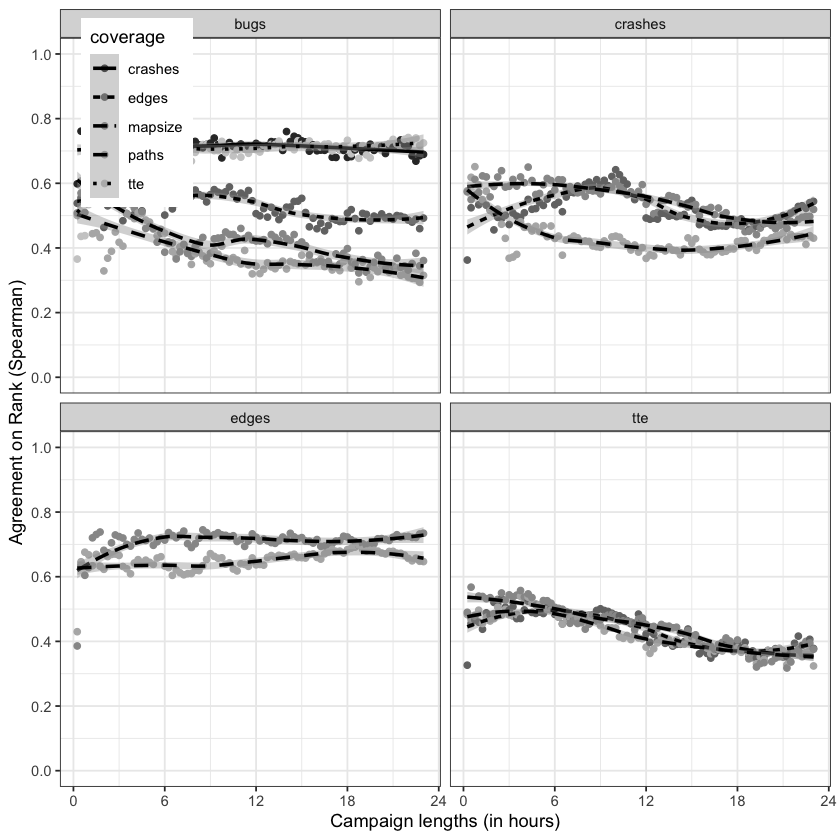

In [26]:

new_dm_ranking_correlation = new_dm_ranking %>% 
  group_by(time) %>% 
  summarize(
    bugs_edges_rank_correlation = cor(edges_rank,bugs_rank,method="spearman",use="pairwise"),
    bugs_paths_rank_correlation = cor(paths_rank,bugs_rank,method="spearman",use="pairwise"),
    bugs_mapsize_rank_correlation = cor(mapsize_rank,bugs_rank,method="spearman",use="pairwise"),
    crashes_edges_rank_correlation = cor(edges_rank,crashes_rank,method="spearman",use="pairwise"),
    crashes_paths_rank_correlation = cor(paths_rank,crashes_rank,method="spearman",use="pairwise"),
    crashes_mapsize_rank_correlation = cor(mapsize_rank,crashes_rank,method="spearman",use="pairwise"),
    tte_edges_rank_correlation = cor(edges_rank,tte_rank,method="spearman",use="pairwise"),
    tte_paths_rank_correlation = cor(paths_rank,tte_rank,method="spearman",use="pairwise"),
    tte_mapsize_rank_correlation = cor(mapsize_rank,tte_rank,method="spearman",use="pairwise"),
    bugs_crashes_rank_correlation = cor(crashes_rank,bugs_rank,method="spearman",use="pairwise"),
    bugs_tte_rank_correlation = cor(tte_rank,bugs_rank,method="spearman",use="pairwise"),
    edges_mapsize_rank_correlation = cor(mapsize_rank,edges_rank,method="spearman",use="pairwise"),
    edges_paths_rank_correlation = cor(paths_rank,edges_rank,method="spearman",use="pairwise")
  ) %>% 
  pivot_longer(
    cols = ends_with("_rank_correlation"),
    names_to = c("dependent","coverage"),
    names_pattern = "(.*)_(.*)_rank_correlation",
    #names_suffix = "_rank_correlation",
    values_to = "correlation",
    values_drop_na = TRUE
  )

subset(new_dm_ranking_correlation, time == 23*3600)

ggplot(subset(new_dm_ranking_correlation, dependent != "n"),
       aes(time/3600,correlation)) +

  geom_point(aes(color = coverage)) +
  geom_smooth(aes(linetype = coverage),color="black") +
  scale_x_continuous(breaks=seq(0,24,6), name=c("Campaign lengths (in hours)")) +
  scale_y_continuous(limits=c(0,1.0), breaks=seq(0,1,0.2), name=c("Agreement on Rank (Spearman)")) +
  facet_wrap(~ dependent) +
  scale_colour_grey() +
  theme(legend.position = c(0.1, 0.9))


## Figure 12.a Baseline Agreement

`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer', 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark', 'time'. You can override using the `.groups` argument.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 3.5 x 3.5 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



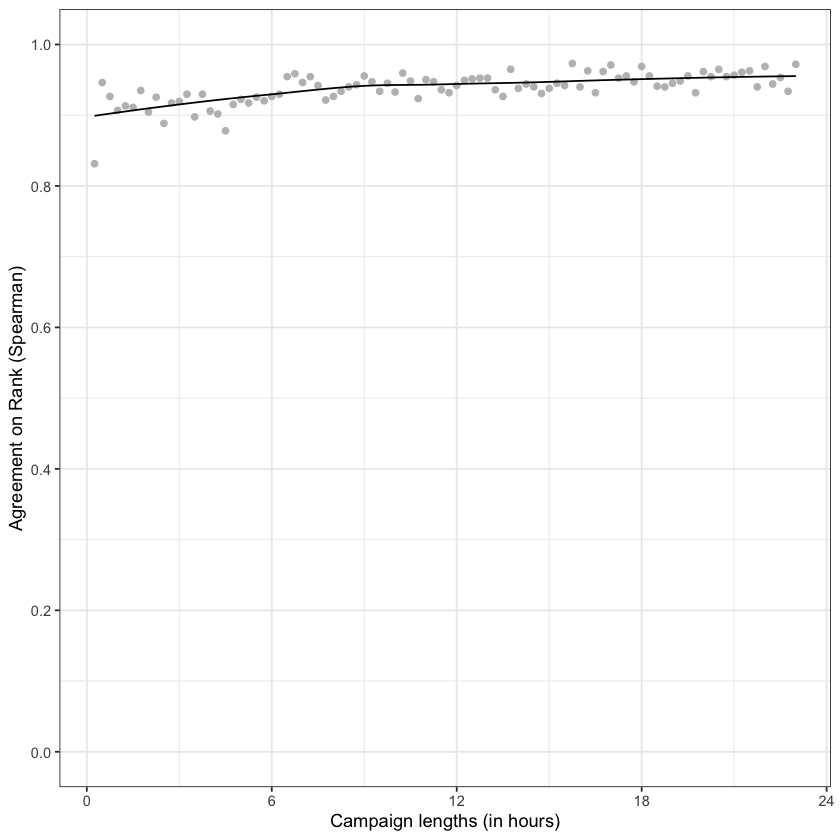

In [27]:
beginning = TRUE
for (repetition in seq(1,1)) {
  fourty_random_trials = trials_d %>%
    group_by(fuzzer,benchmark,time) %>% 
    sample_n(40,replace=FALSE)

  twenty_random_trials1 = fourty_random_trials %>%
    slice_max(as.integer(trial_id),n=20) %>%
    summarize(edges = mean(edges_covered))
  twenty_random_trials1$side = "left"

  twenty_random_trials2 = fourty_random_trials %>%
    slice_min(as.integer(trial_id),n=20) %>%
    summarize(edges = mean(edges_covered))
  twenty_random_trials2$side = "right"

  merged_random_trials = rbind(twenty_random_trials1,twenty_random_trials2) %>%
    select(benchmark, fuzzer, time, side, edges) %>%
    pivot_wider(names_from = "side", values_from="edges") 
  head(merged_random_trials)

  merged_random_trials = merged_random_trials %>%
    group_by(benchmark, time) %>% 
    summarize(
      left_rank=rank(-left, ties.method=RANKING_TIES_METHOD),
      right_rank=rank(-right, ties.method=RANKING_TIES_METHOD)
    ) %>%
    group_by(time) %>%
    summarize(correlation = cor(left_rank,right_rank,method="spearman",use="pairwise"))
  merged_random_trials$repetition = repetition

  if (beginning) {
    cov_cov_df = merged_random_trials
    beginning = FALSE
  } else {
    cov_cov_df = rbind(cov_cov_df, merged_random_trials)
  }
}
cov_cov_dm = cov_cov_df %>% group_by(time) %>% summarize(correlation = mean(correlation))
ggplot(cov_cov_dm, aes(time/3600,correlation)) +
  geom_point(data=cov_cov_df, color="grey") +
  stat_smooth(geom='line', n=48)+
  scale_x_continuous(breaks=seq(0,24,6), name=c("Campaign lengths (in hours)")) +
  scale_y_continuous(limits=c(0,1.0), breaks=seq(0,1,0.2), name=c("Agreement on Rank (Spearman)")) +
  scale_color_manual(breaks=c("bugs","tte"),values=c("black","#666666")) +
  theme(legend.position = c(0.5, 0.1),legend.title=element_blank(), legend.direction="horizontal")
ggsave("agreement.cov.cov.pdf",scale=0.5)

## Agreement on Superiority

In [28]:
defaultW <- getOption("warn")
options(warn = -1)

new_compute_d = function(specific) {
  to_return = data.frame()#fuzzer0"=character(), "fuzzer1"=character(),
                         #"cov"=integer(),"bugs"=integer(),
                         #"cov_signif"=numeric(), "bugs_signif"=numeric())
  fuzzers = levels(factor(specific$fuzzer))
  for (i in seq(1,length(fuzzers)-1)) {
    for (j in seq(i+1,length(fuzzers))) {
      Fuzzer0 = fuzzers[i]
      Fuzzer1 = fuzzers[j]
      f0 = subset(specific, fuzzer == Fuzzer0)
      f1 = subset(specific, fuzzer == Fuzzer1)

      Edges_mean = ifelse(mean(f0$edges_covered) > mean(f1$edges_covered),0,1)
      Mapsize_mean = ifelse(mean(f0$mapsize) > mean(f1$mapsize),0,1)
      Paths_mean = ifelse(mean(f0$paths) > mean(f1$paths),0,1)
      Bugs_mean = ifelse(mean(f0$bugs_covered) > mean(f1$bugs_covered),0,1)
      Crashes_mean = ifelse(mean(f0$crashes) > mean(f1$crashes),0,1)
      TTE_mean = ifelse(mean(f0$tte) < mean(f1$tte),0,1)

      Edges_median = ifelse(median(f0$edges_covered) > median(f1$edges_covered),0,1)
      Mapsize_median = ifelse(median(f0$mapsize) > median(f1$mapsize),0,1)
      Paths_median = ifelse(median(f0$paths) > median(f1$paths),0,1)
      Bugs_median = ifelse(median(f0$bugs_covered) > median(f1$bugs_covered),0,1)
      Crashes_median = ifelse(median(f0$crashes) > median(f1$crashes),0,1)
      TTE_median = ifelse(median(f0$tte) < median(f1$tte),0,1)

      Edges_signif = wilcox.test(f0$edges_covered, f1$edges_covered, paired=FALSE)$p.value
      Mapsize_signif = tryCatch(expr = wilcox.test(f0$mapsize, f1$mapsize, paired=FALSE)$p.value,error = function(e) 1)
      Paths_signif = tryCatch(expr = wilcox.test(f0$paths, f1$paths, paired=FALSE)$p.value,error = function(e) NA)
      Bugs_signif = wilcox.test(f0$bugs_covered, f1$bugs_covered, paired=FALSE)$p.value
      Crashes_signif = tryCatch(expr = wilcox.test(f0$crashes, f1$crashes, paired=FALSE)$p.value,error = function(e) 1)
      TTE_signif = tryCatch(expr = wilcox.test(f0$tte, f1$tte, paired=FALSE)$p.value,error = function(e) 1)

      to_return = rbind(to_return, data.frame(
        fuzzer0 = Fuzzer0, fuzzer1 = Fuzzer1,
        edges_mean = Edges_mean, mapsize_mean = Mapsize_mean, paths_mean = Paths_mean, bugs_mean = Bugs_mean, crashes_mean = Crashes_mean, tte_mean = TTE_mean,
        edges_median = Edges_median, mapsize_median = Mapsize_median, paths_median = Paths_median, bugs_median = Bugs_median, crashes_median = Crashes_median, tte_median = TTE_median,
        edges_signif = Edges_signif, mapsize_signif = Mapsize_signif, paths_signif = Paths_signif,
        bugs_signif = Bugs_signif, crashes_signif = Crashes_signif, tte_signif = TTE_signif
      ))
    }
  }
  return(to_return)
}

new_d_pairs = new_d %>%
  group_by(benchmark, time) %>% 
  group_modify(~ new_compute_d(.x)) %>%
  pivot_longer(
    cols = contains("_"),
    names_to = c("type","aggregator"),
    names_pattern = "(.*)_(.*)",
    #names_suffix = "_rank_correlation",
    values_to = "value",
    values_drop_na = TRUE
  ) %>% 
  pivot_wider(
    names_from = "aggregator",
    values_from = "value"
  ) %>%
  mutate(signif = replace_na(signif, 1))


summary(new_d_pairs)

options(warn = defaultW)

                         benchmark           time         fuzzer0         
 arrow_parquet-arrow-fuzz     : 11592   Min.   :  900   Length:183816     
 njs_njs_process_script_fuzzer: 11592   1st Qu.:21375   Class :character  
 openh264_decoder_fuzzer      : 11592   Median :41850   Mode  :character  
 aspell_aspell_fuzzer         : 11592   Mean   :41850                     
 grok_grk_decompress_fuzzer   : 11592   3rd Qu.:62325                     
 libgit2_objects_fuzzer       : 11592   Max.   :82800                     
 (Other)                      :114264                                     
   fuzzer1              type                mean            median      
 Length:183816      Length:183816      Min.   :0.0000   Min.   :0.0000  
 Class :character   Class :character   1st Qu.:0.0000   1st Qu.:0.0000  
 Mode  :character   Mode  :character   Median :0.0000   Median :1.0000  
                                       Mean   :0.4714   Mean   :0.5744  
                                   

## Figure 8. Agreement Table

In [38]:
print_agreement_table = function(cov_types, bug_types, signif_types, File) {
  cat(file=File,"\n")

  cat(file=File,paste("\\textbf{Ranking} & $\\rho =$",sep=""), append=TRUE)
  for(Type0 in cov_types) {  
    for (Type1 in bug_types) {
      t = subset(new_dm_ranking_correlation, 
        coverage == Type0 & 
        dependent == Type1 & 
        time == max_time)
      cat(file=File,paste("&",format(round(t$correlation,digits=3),nsmall=3),sep=""), append=TRUE)
    }
  }
  cat(file=File,"\\\\\\hline\n", append=TRUE)

  for (is_disagreement in c(FALSE,TRUE)) {
    
    for (Signif in signif_types) {
      cat(file=File,paste("\\textbf{Superiority} ($p\\le ",format(Signif,scientific = F),"$) &",sep=""), append=TRUE)
      if (is_disagreement) {
        cat(file=File,"$d =$", append=TRUE)
      } else {
        cat(file=File,"$\\kappa =$", append=TRUE)
      }

      for(Type0 in cov_types) {  
        for (Type1 in bug_types) {
          t0 = subset(new_d_pairs, type == Type0 & time == max_time & signif <= Signif)
          t1 = subset(new_d_pairs, type == Type1 & time == max_time & signif <= Signif)
          #Uncomment for Figure 14.b
          #t1 = subset(new_d_pairs, type == Type1 & time == max_time)

          t0 = t0 %>% mutate(id=paste(benchmark,fuzzer0,fuzzer1,sep="_"))
          t1 = t1 %>% mutate(id=paste(benchmark,fuzzer0,fuzzer1,sep="_"))

          t0_ids = unique(t0$id)
          t1_ids = unique(t1$id)
          joint_ids = intersect(t0_ids, t1_ids)
          t0 = subset(t0,id %in% joint_ids)
          t1 = subset(t1,id %in% joint_ids)
          t = t0 %>% ungroup() %>% select(-mean, -median, -signif, -type, -time)
          if (all(t0$id != t1$id)) print("[ERROR] Not aligned") #impossible
          
          t$mean0 = t0$mean
          t$mean1 = t1$mean
          t$median0 = t0$median
          t$median1 = t1$median

          superiority = subset(
              t %>% 
                group_by(fuzzer0, fuzzer1) %>% 
                summarize(
                  benchmarks = n(),
                  kappa = kappa2(cur_data() %>% select(mean0,mean1), weight="unweighted")$value,
                  kappa = replace(kappa, is.na(kappa), 1),
                  disagreement = sum(cur_data()$mean0 != cur_data()$mean1)/nrow(cur_data())
                  #Uncomment for Figure 14.a
                  #kappa = kappa2(cur_data() %>% select(median0,median1), weight="unweighted")$value,
                  #kappa = replace(kappa, is.na(kappa), 1),
                  #disagreement = sum(cur_data()$median0 != cur_data()$median1)/nrow(cur_data())
                ),
              benchmarks >= 3) #At least 10% of programs.

          if (is_disagreement) {
            value = mean(superiority$disagreement)
          } else {
            value = mean(superiority$kappa)
          }
          cat(file=File,
            paste("&",
              format(round(value,digits=3),nsmall=3),
              " \\smaller (",format(round(100*nrow(superiority)/45,digits=0),nsmall=0),"\\%)",
              sep=""), 
            append=TRUE)
        }
      }
      cat(file=File,"\\\\\n", append=TRUE)
    }
    cat(file=File,"\\hline\n", append=TRUE)
  }
  beginning = TRUE
  for (Signif in signif_types) {
    if (beginning) {
      beginning = FALSE
    } else {
      cat(file=File,"\\\\\n", append=TRUE)
    }
    cat(file=File,paste("\\textbf{Superiority} ($p\\le ",format(Signif,scientific = F),"$) &",sep=""), append=TRUE)
    cat(file=File,"$\\rho =$", append=TRUE)
    
    temp = new_d_pairs_wide %>%
      ungroup() %>%          
      mutate(
        mean_bugs=ifelse(mean_bugs == 0, -1, 1),
        mean_bugs=ifelse(signif_bugs > Signif, 0, mean_bugs),
        mean_tte=ifelse(mean_tte == 0, -1, 1),
        mean_tte=ifelse(signif_tte > Signif, 0, mean_tte),
        mean_crashes=ifelse(mean_crashes == 0, -1, 1),
        mean_crashes=ifelse(signif_crashes > Signif, 0, mean_crashes),
        mean_edges=ifelse(mean_edges == 0, -1, 1),
        mean_edges=ifelse(signif_edges > Signif, 0, mean_edges),
        mean_paths=ifelse(mean_paths == 0, -1, 1),
        mean_paths=ifelse(signif_paths > Signif, 0, mean_paths),
        mean_mapsize=ifelse(mean_mapsize == 0, -1, 1),
        mean_mapsize=ifelse(signif_mapsize > Signif, 0, mean_mapsize)
      ) %>%
      group_by(time) %>%
      summarize(
        benchmarks = n(),
        value_edges_tte = cor(as.integer(mean_edges), as.integer(mean_tte),  method="spearman",use="pairwise"),
        value_edges_bugs = cor(as.integer(mean_edges), as.integer(mean_bugs),  method="spearman",use="pairwise"),
        value_mapsize_tte = cor(as.integer(mean_mapsize), as.integer(mean_tte),  method="spearman",use="pairwise"),
        value_mapsize_bugs = cor(as.integer(mean_mapsize), as.integer(mean_bugs),  method="spearman",use="pairwise"),
        value_paths_tte = cor(as.integer(mean_paths), as.integer(mean_tte),  method="spearman",use="pairwise"),
        value_paths_bugs = cor(as.integer(mean_paths), as.integer(mean_bugs),  method="spearman",use="pairwise"),
        value_tte_bugs = cor(as.integer(mean_tte), as.integer(mean_bugs),  method="spearman",use="pairwise"),
        value_crashes_bugs = cor(as.integer(mean_crashes), as.integer(mean_bugs),  method="spearman",use="pairwise"),
        value_mapsize_edges = cor(as.integer(mean_mapsize), as.integer(mean_edges),  method="spearman",use="pairwise"),
        value_paths_edges = cor(as.integer(mean_paths), as.integer(mean_edges),  method="spearman",use="pairwise")
      ) %>% 
      pivot_longer(
        cols=starts_with("value"), 
        names_to = c("type0","type1"), 
        names_pattern = "value_(.*)_(.*)",
        values_to = "value"
      )
        
    for(Type0 in cov_types) {  
      for (Type1 in bug_types) {
        value = subset(temp, time==23*3600 & type0 == Type0 & type1 == Type1)$value
        cat(file=File,
            paste("&",
              format(round(value,digits=3),nsmall=3),
              sep=""), 
            append=TRUE)
      }
    }
  }
}


options(warn = -1)

new_d_pairs_wide = new_d_pairs %>% 
  select(-median) %>% 
  pivot_wider(names_from=type, values_from = c(mean,signif))

signif_types = c(0.05,0.001,0.0001)
print_agreement_table(c("edges","mapsize","paths"), c("bugs","tte"), signif_types, "agreement.tex")
print_agreement_table(c("tte","crashes"), c("bugs"), signif_types, "bugsAgree.tex")
print_agreement_table(c("mapsize","paths"), c("edges"), signif_types, "covAgree.tex")

options(warn = defaultW)

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'fuzzer0'. You

## Figure 9.a Agreement on rank over time

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 3.5 x 3.5 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



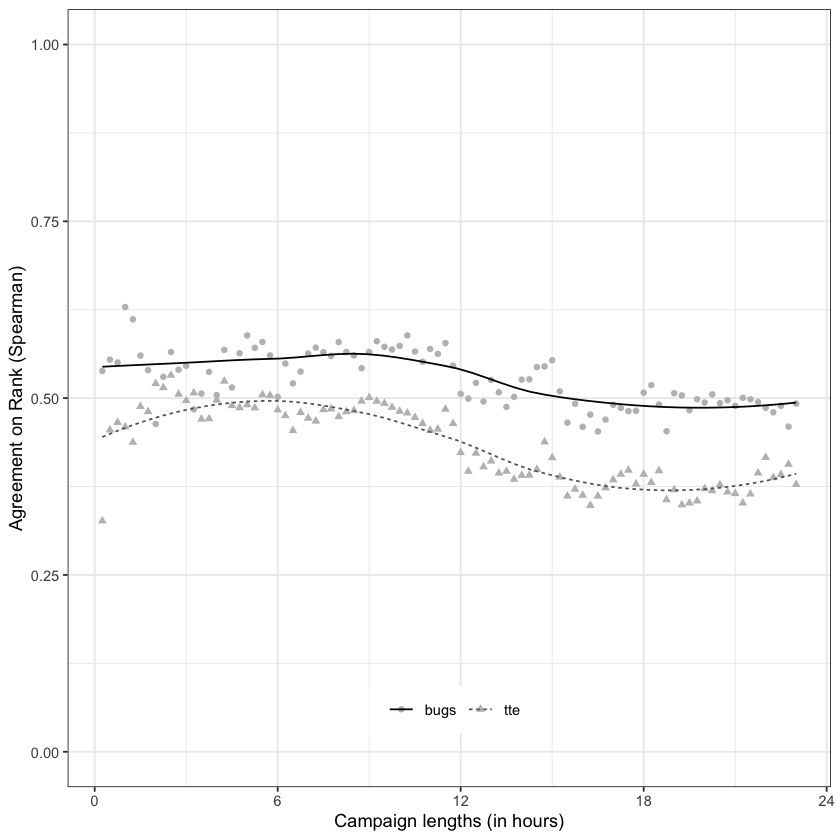

In [30]:
ggplot(subset(new_dm_ranking_correlation,coverage=="edges" & dependent %in% c("tte","bugs")), aes(time/3600,correlation)) +
  #geom_rect(ymin = -Inf, ymax = lwWt, xmin = -Inf, xmax = Inf, fill = 'darkorange') +
  geom_point(aes(shape=dependent),color="grey") +
  stat_smooth(geom='line', n=48, aes(linetype=dependent,color=dependent))+
  scale_x_continuous(breaks=seq(0,24,6), name=c("Campaign lengths (in hours)")) +
  scale_y_continuous(limits=c(0,1.0), name=c("Agreement on Rank (Spearman)")) +
  scale_color_manual(breaks=c("bugs","tte"),values=c("black","#666666")) +
  theme(legend.position = c(0.5, 0.1),legend.title=element_blank(), legend.direction="horizontal")
  
ggsave("agreement.over.time.pdf",scale=0.5)

## Figure 9 b-d. Agreement on Superiority (Cohen and Disagreement Proportion)

In [35]:
disagreement = function(two_vectors, is_disagreement) {
  two_vectors=data.frame(two_vectors)
  two_vectors[,1] = factor(two_vectors[,1],levels=c(0,1))
  two_vectors[,2] = factor(two_vectors[,2],levels=c(0,1))

  if (is_disagreement) {
    t = table(two_vectors)
    return((t[2] + t[3]) / (t[1] + t[2] + t[3] + t[4]))
  } else {
    return(kappa2(two_vectors, weight="unweighted")$value)
  }
}

for (is_disagreement in c(FALSE,TRUE)) {
  for (bugs_also_signif in c(FALSE,TRUE)) {
    beginning = TRUE
    for (Signif in signif_types) {
      for (type in c("bugs","tte","crashes")) {
        temp = 
          subset(new_d_pairs_wide, 
            signif_edges <= Signif &
            # If bugs_also_signif, also make sure that difference in bug-measure are signif.
            (!bugs_also_signif | eval(as.symbol(paste("signif_",type,sep=""))) <= Signif)
          ) %>%
          group_by(time, fuzzer0, fuzzer1) %>%
          summarize(
            benchmarks = n(),
            t = disagreement(
                  cur_data() %>% 
                    select(mean_edges, as.symbol(paste("mean_",type,sep=""))),
                  is_disagreement), 
            !!paste("kappa_",type,sep="") := replace(t, is.na(t), 1)
          )%>%
          select(-t)
        temp$signif = Signif
        if (beginning) {
          agreement_over_time = temp
          beginning = FALSE
        } else {
          agreement_over_time = rbind(agreement_over_time, temp)
        }
      }
    }

    agreement_over_time = agreement_over_time %>% 
      pivot_longer(
        cols = starts_with("kappa_"),
        names_to = "type",
        names_pattern = "kappa_(.*)",
        values_to = "cohens_kappa",
        values_drop_na = TRUE
      )

    agreement_over_time = subset(agreement_over_time, benchmarks >= 3) %>%
      ungroup() %>%
      group_by(type, signif, time) %>%
      summarize(cohens_kappa = mean(cohens_kappa), pairs=n())

    for (Signif in signif_types) {
      legend_position = 0.15
      if (is_disagreement) {
        legend_position=0.85
      }
      if(!bugs_also_signif) {
        legend_position=0.85
      }
      
      g = ggplot(subset(agreement_over_time, signif == Signif & type != "crashes")) +
        geom_point(aes(time/3600, cohens_kappa, shape=type,color=pairs/45)) +
        stat_smooth(geom='line', n=48, aes(time/3600, cohens_kappa,linetype=type))+
        scale_x_continuous(breaks=seq(0,24,6), name=c("Campaign lengths (in hours)")) +
        #scale_color_manual(breaks=c("bugs","crashes","tte"),values=c("black","#666666","#666666")) +
        scale_color_viridis_c(limits=c(0,0.4),labels=scales::percent,breaks=c(0,0.2,0.4)) +
        theme(
          legend.position = c(0.5, legend_position),
          legend.title=element_blank(), 
          legend.direction="horizontal",
          legend.margin=margin(-5,-5,-5,-5),
          legend.box.margin=margin(-10,-10,-10,-10),
          legend.box.just="right")
      if (is_disagreement){
        g + scale_y_continuous(limits=c(0,0.4), name="Disagreement on Superiority (%Programs)", labels=scales::percent)
      } else {
        g + scale_y_continuous(limits=c(0,1.0), breaks=seq(0,1,0.2),name="Agreement on Superiority (Cohen)")
      }

      string1 = ".bugs.notsignif"
      if (bugs_also_signif) string1 = ".bugs.signif"
      string2 = ".cohen"
      if (is_disagreement) string2 = ".disagreement"
      ggsave(paste("agreement.tuples.",format(Signif,scientific = F),string1,string2,".pdf",sep=""),scale=0.5)
    }
  }
}

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'time', 'fuzzer0'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'type', 'signif'. You can override us

## Figure 10.a Agreement over time

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'benchmark'. You can override using the `.groups` argument.

`summarise()` has grouped outp

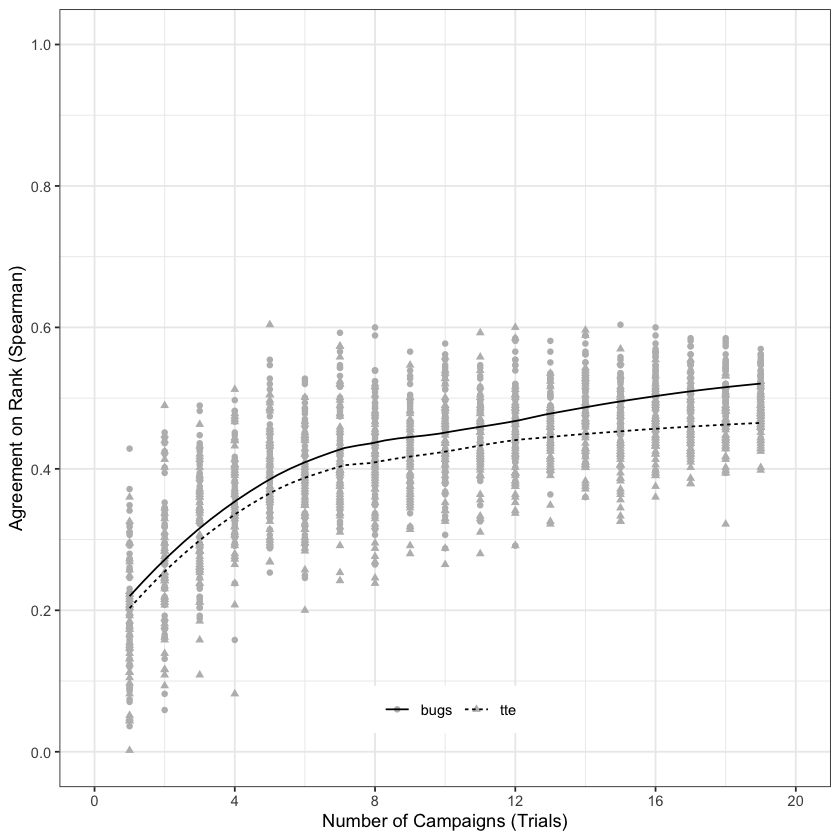

In [32]:
defaultW <- getOption("warn")
options(warn = -1)

n_trials=19
temp_df20 = NULL
for (repetition in seq(1,50)) {
  cors=c()
  for (trials in seq(1,n_trials)) {
    temp = 
      subset(new_d, 
        time == 23 * 3600 & 
        fuzzer != "eclipser" & benchmark != "libhevc_hevc_dec_fuzzer" & benchmark != "arrow_parquet-arrow-fuzz") %>% 
      group_by(benchmark,fuzzer) %>%
      summarize(
        edges = mean(sample(edges_covered,trials), na.rm=TRUE), 
        bugs = mean(sample(bugs_covered,trials), na.rm=TRUE),
        crashes = mean(sample(crashes,trials), na.rm=TRUE),
        tte = mean(sample(tte,trials), na.rm=TRUE)
      ) %>%
      group_by(benchmark) %>% 
      mutate(
        edges_rank=rank(-edges, ties.method=RANKING_TIES_METHOD),
        bugs_rank=rank(-bugs, ties.method=RANKING_TIES_METHOD),
        crashes_rank=rank(-crashes, ties.method=RANKING_TIES_METHOD),
        tte_rank=rank(tte, ties.method=RANKING_TIES_METHOD),
      ) %>%
      group_by() %>%
      summarize(
        bugs_edges_rank_correlation = cor(edges_rank,bugs_rank,method="spearman",use="pairwise"),
        crashes_edges_rank_correlation = cor(edges_rank,crashes_rank,method="spearman",use="pairwise"),
        tte_edges_rank_correlation = cor(edges_rank,tte_rank,method="spearman",use="pairwise"),
      ) %>% 
      pivot_longer(
        cols = ends_with("_rank_correlation"),
        names_to = "type",
        names_pattern = "(.*)_edges_rank_correlation",
        values_to = "correlation",
        values_drop_na = TRUE
      )
    temp$trials = trials
    temp$repetition = repetition
    if (is.null(temp_df20)) {
      temp_df20 = temp
    } else {
      temp_df20 = rbind(temp_df20, temp)
    }
  }
}

temp_dm20 = temp_df20 %>% group_by(type,trials) %>% summarize(correlation = mean(correlation))
ggplot(subset(temp_df20, type!="crashes"), aes(trials,correlation)) +
  geom_point(aes(shape=type),color="#bbbbbb") +
  stat_smooth(geom='line', n=48, aes(linetype=type))+
  scale_x_continuous(breaks=seq(0,20,4), limits=c(0,20), name=c("Number of Campaigns (Trials)")) +
  scale_y_continuous(limits=c(0,1.0), breaks=seq(0,1,0.2),name=c("Agreement on Rank (Spearman)")) +
  theme(legend.position = c(0.5, 0.1),legend.title=element_blank(), legend.direction="horizontal")
  ggsave("agreement.trials.20.pdf",scale=0.5)

options(warn = defaultW)

## Figure 12.b Agreement as the Number of Benchmark Increases

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 3.15 x 3.15 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



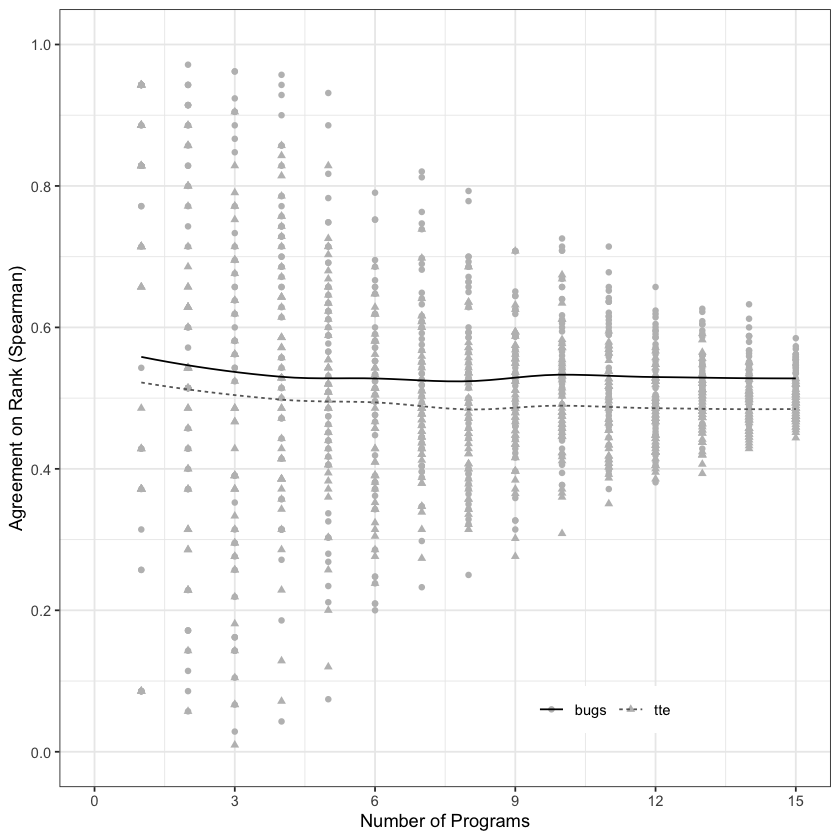

In [33]:
defaultW <- getOption("warn")
options(warn = -1)

n_benchmarks=15
new_dms = subset(new_dm, 
        time == 23 * 3600 & 
        fuzzer != "eclipser" & benchmark != "libhevc_hevc_dec_fuzzer" & benchmark != "arrow_parquet-arrow-fuzz")

temp_dfb = NULL
for (repetition in seq(1,50)) {
  cors=c()
  for (trials in seq(1,n_benchmarks)) {
    temp = 
      subset(new_dms, benchmark %in% sample(levels(factor(new_dms$benchmark)), trials))%>%
      group_by(benchmark) %>% 
      mutate(
        edges_rank=rank(-edges_covered, ties.method=RANKING_TIES_METHOD),
        bugs_rank=rank(-bugs_covered, ties.method=RANKING_TIES_METHOD),
        crashes_rank=rank(-crashes, ties.method=RANKING_TIES_METHOD),
        tte_rank=rank(tte, ties.method=RANKING_TIES_METHOD),
      ) %>%
      group_by() %>%
      summarize(
        bugs_edges_rank_correlation = cor(edges_rank,bugs_rank,method="spearman",use="pairwise"),
        crashes_edges_rank_correlation = cor(edges_rank,crashes_rank,method="spearman",use="pairwise"),
        tte_edges_rank_correlation = cor(edges_rank,tte_rank,method="spearman",use="pairwise"),
      ) %>% 
      pivot_longer(
        cols = ends_with("_rank_correlation"),
        names_to = "type",
        names_pattern = "(.*)_edges_rank_correlation",
        values_to = "correlation",
        values_drop_na = TRUE
      )
    temp$trials = trials
    temp$repetition = repetition
    if (is.null(temp_dfb)) {
      temp_dfb = temp
    } else {
      temp_dfb = rbind(temp_dfb, temp)
    }
  }
}

temp_dfb = subset(temp_dfb, type!="crashes")

temp_dmb = temp_dfb %>% group_by(type,trials) %>% summarize(correlation = mean(correlation))
ggplot(temp_dfb , aes(trials,correlation)) +
  #geom_rect(ymin = -Inf, ymax = lwWt, xmin = -Inf, xmax = Inf, fill = 'darkorange') +
  geom_point(aes(shape=type),color="grey") +
  stat_smooth(data=temp_dmb,geom='line', n=48, aes(trials,correlation,linetype=type,color=type))+
  scale_x_continuous(breaks=seq(0,15,3), limits=c(0,15), name=c("Number of Programs")) +
  scale_y_continuous(limits=c(0,1.0), breaks=seq(0,1,0.2),name=c("Agreement on Rank (Spearman)")) +
  scale_color_manual(breaks=c("bugs","crashes","tte"),values=c("black","#666666","#666666")) +
  theme(legend.position = c(0.7, 0.1),legend.title=element_blank(), legend.direction="horizontal")
ggsave("agreement.benchmarks.pdf",scale=0.45)

options(warn = defaultW)